I submitted this notebook for the in-house competition of the course "Data Mining Models and Algorithms" of the training "Mathematical Expert in Data Analysis and Machine Learning". I finished in 2nd place based on my public score on Kaggle.

# Imports

In [81]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
pd.pandas.set_option('display.max_columns',None)
pd.set_option('display.max_rows', None)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve, ShuffleSplit, KFold
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import Lasso
import scipy.stats as stats
from scipy.stats import skew, norm
from sklearn.pipeline import make_pipeline
from yellowbrick.regressor import ResidualsPlot, PredictionError
from statsmodels.stats.diagnostic import normal_ad
import optuna

In [2]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
df = pd.concat([train_df, test_df]).reset_index(drop=True)

# Exploratory Data Analysis

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2919 entries, 0 to 2918
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             2919 non-null   int64  
 1   MSSubClass     2919 non-null   int64  
 2   MSZoning       2915 non-null   object 
 3   LotFrontage    2433 non-null   float64
 4   LotArea        2919 non-null   int64  
 5   Street         2919 non-null   object 
 6   Alley          198 non-null    object 
 7   LotShape       2919 non-null   object 
 8   LandContour    2919 non-null   object 
 9   Utilities      2917 non-null   object 
 10  LotConfig      2919 non-null   object 
 11  LandSlope      2919 non-null   object 
 12  Neighborhood   2919 non-null   object 
 13  Condition1     2919 non-null   object 
 14  Condition2     2919 non-null   object 
 15  BldgType       2919 non-null   object 
 16  HouseStyle     2919 non-null   object 
 17  OverallQual    2919 non-null   int64  
 18  OverallC

Quite a lot missing values. Different datatypes, both categorical and numerical.<br>
Removing the ID:

In [3]:
df.drop('Id', inplace=True, axis=1)
train_df.drop('Id', inplace=True, axis=1)
test_df.drop('Id', inplace=True, axis=1)

In [4]:
categorical_features = [feature for feature in df.columns if df[feature].dtype == 'object']
numerical_features = [feature for feature in df.columns if df[feature].dtype != 'object']
discrete_features = [feature for feature in numerical_features if len(df[feature].unique()) <= 25]
continuous_features = [feature for feature in numerical_features if len(df[feature].unique()) > 25]
print(len(continuous_features) + len(discrete_features) == len(numerical_features))
print(len(numerical_features) + len(categorical_features) == len(df.columns))

True
True


## Continuous variables

In [5]:
def diagnostic_plots(df, variable):
    # distplot with theoretical norm
    plt.figure(figsize=(16, 4))
    plt.subplot(1, 3, 1)
    sns.distplot(df[variable], fit=norm, bins=30, color='b')
    plt.title(variable)
    # Q-Q plot
    plt.subplot(1, 3, 2)
    stats.probplot(df[variable], dist="norm", plot=plt)
    plt.ylabel('Variable quantiles')
    plt.title(variable)
    # boxplot
    plt.subplot(1, 3, 3)
    sns.boxplot(y=df[variable])
    plt.title(variable)
    plt.show()

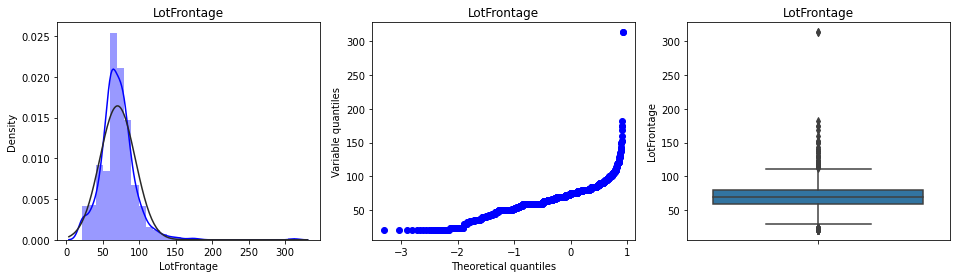

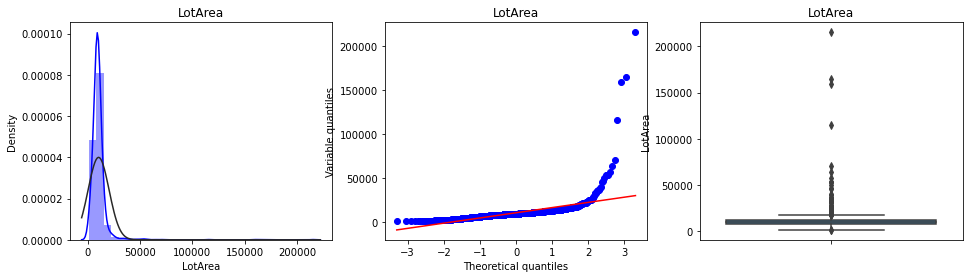

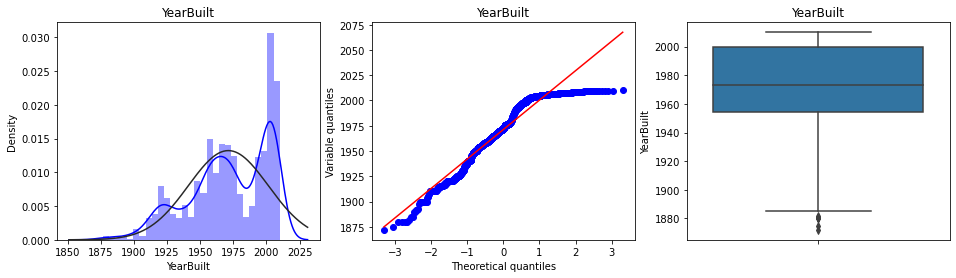

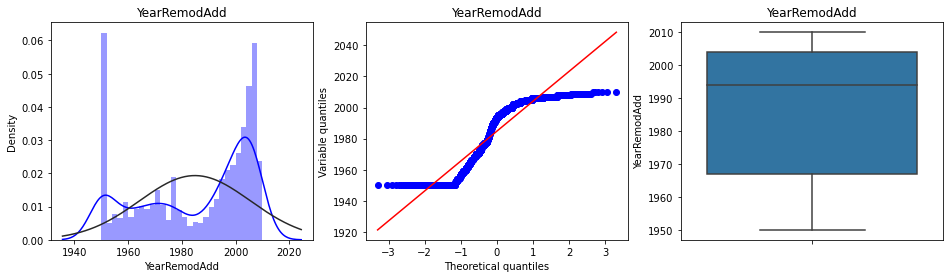

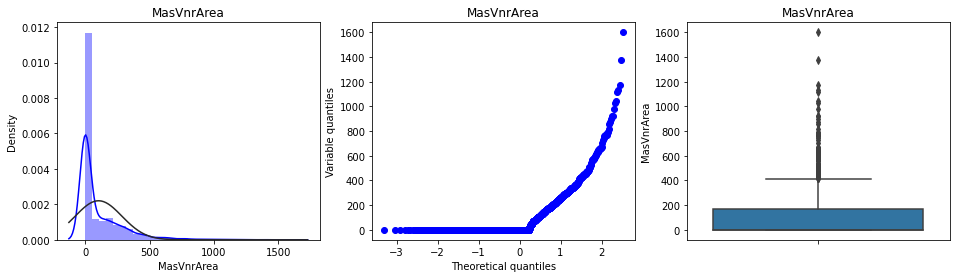

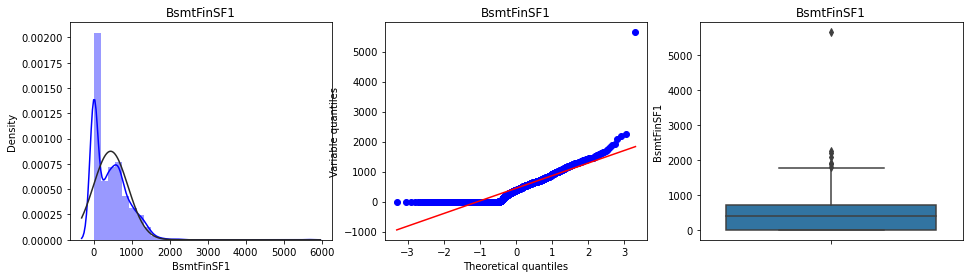

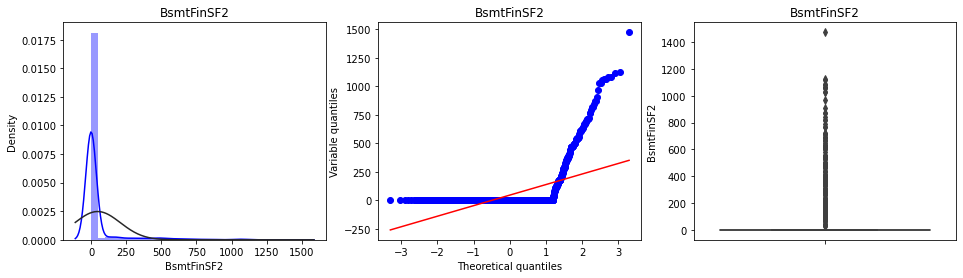

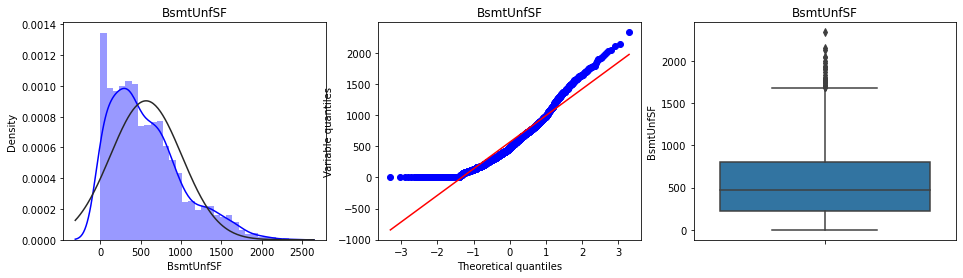

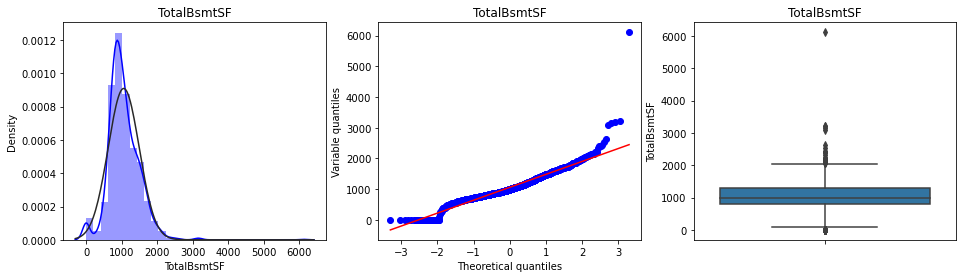

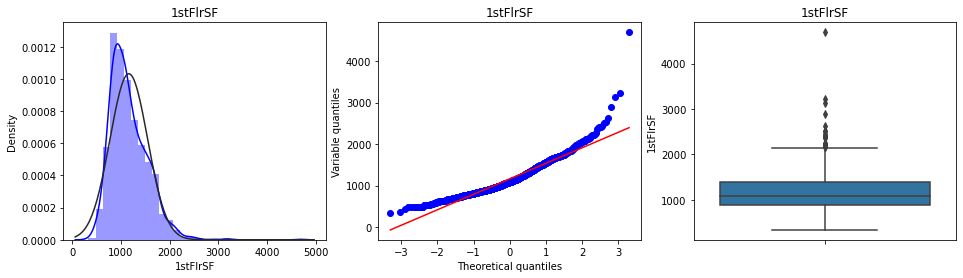

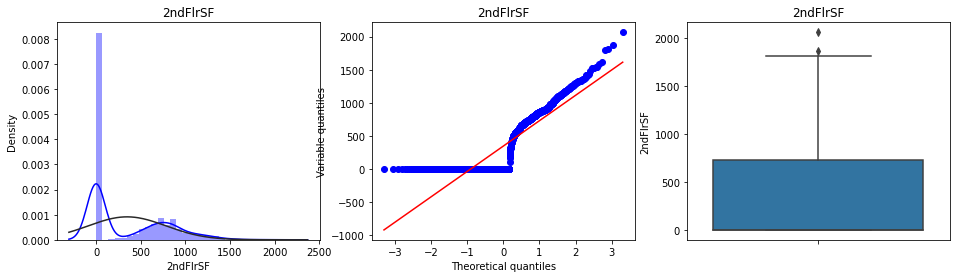

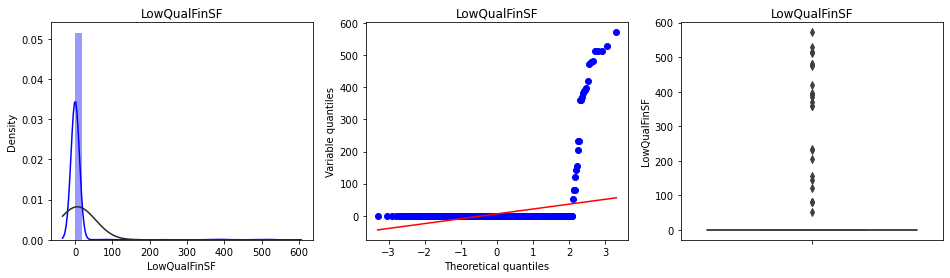

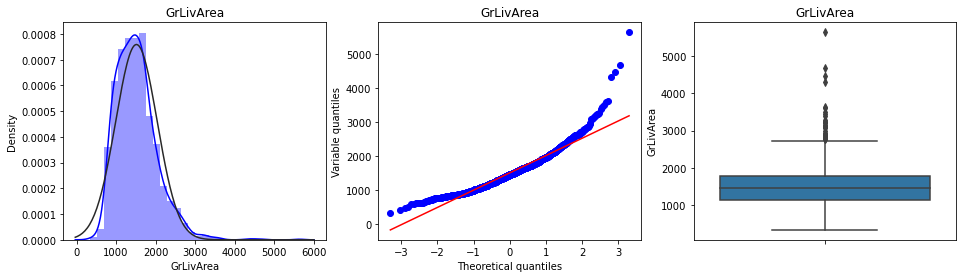

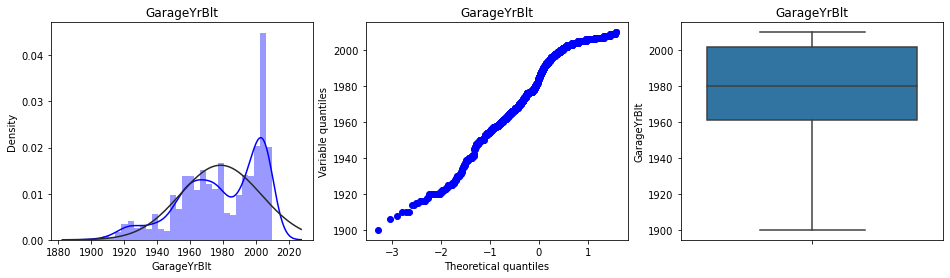

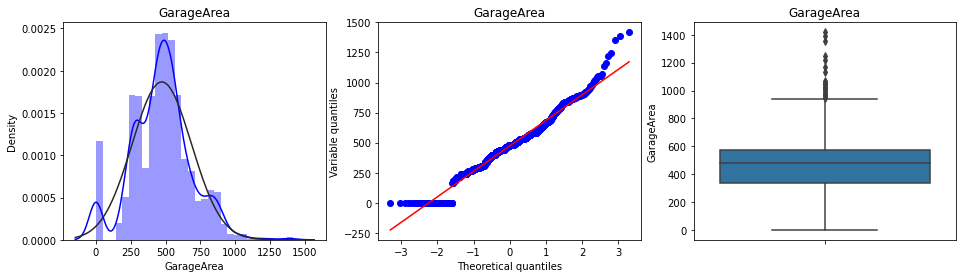

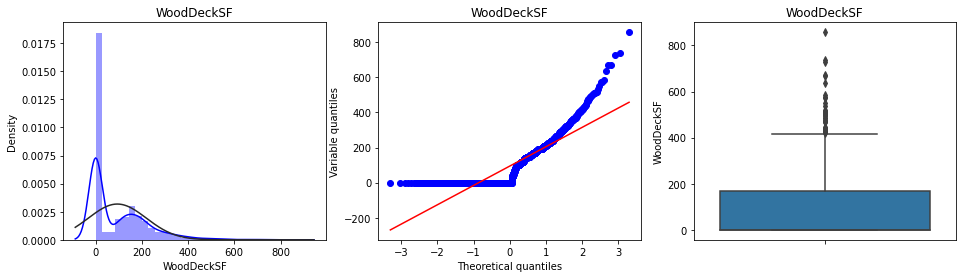

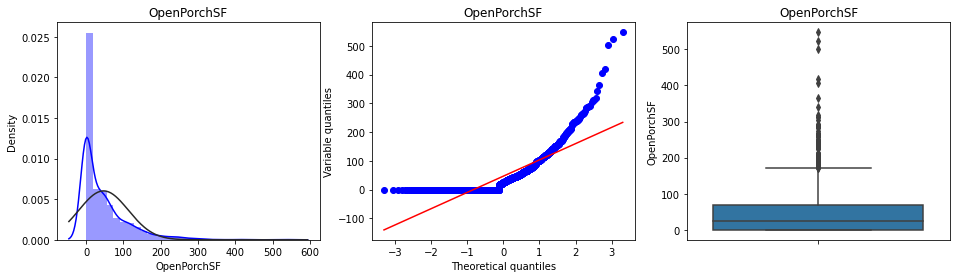

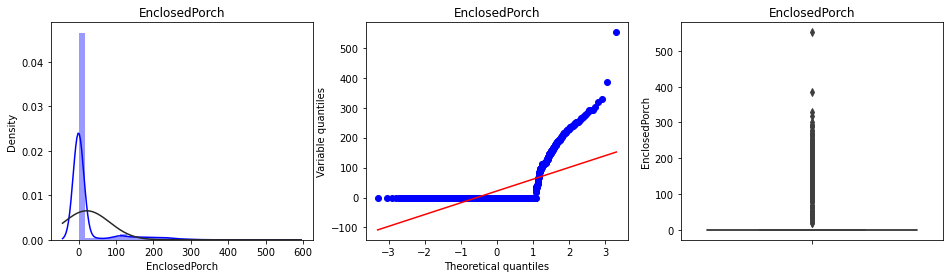

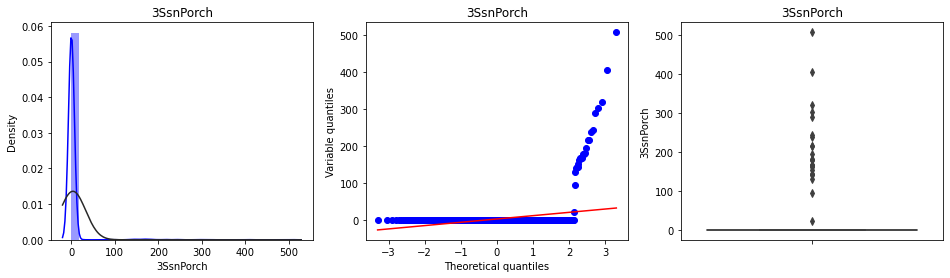

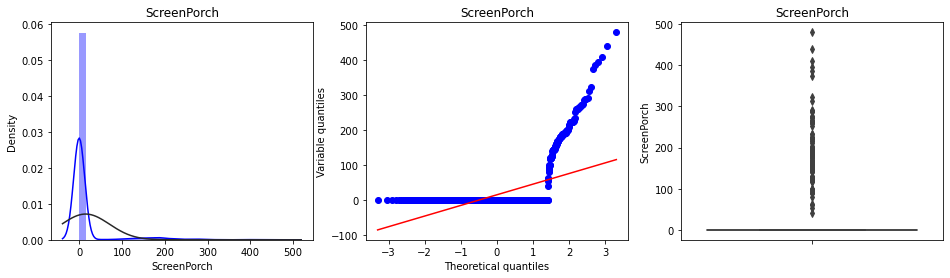

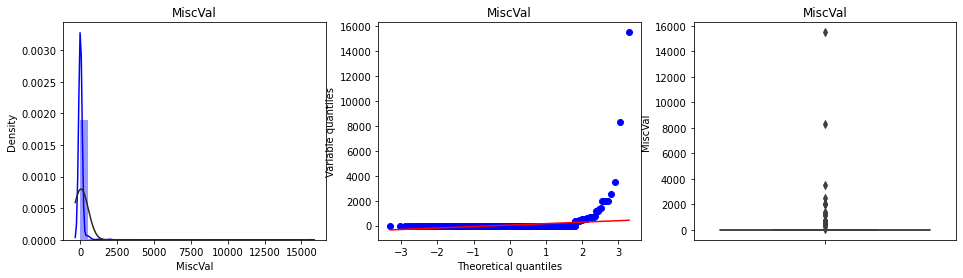

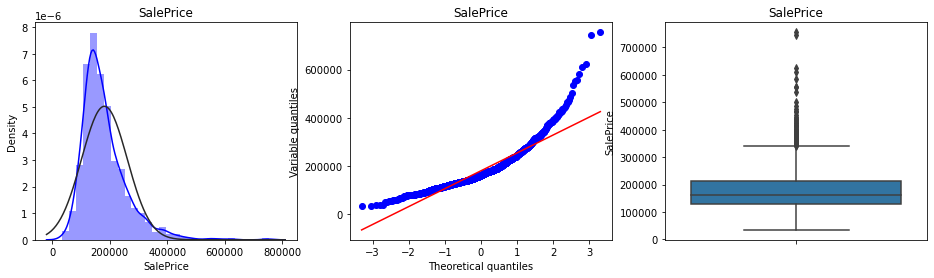

In [87]:
for feature in continuous_features:
    diagnostic_plots(train_df, feature)

Some observations:
* GarageYrBlt 2200 is an anomaly, have to correct it. (Actually I accidently made the plots for the complete dataframe and that's how observed that issue.)
* The value of the response variable ranges quite widely and has positive skew, have to apply log transform.
* Some of the distributions have long tails.
* Clearly quite a few outliers.

In [6]:
df[df['GarageYrBlt']>2010]

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
2592,20,RL,68.0,8298,Pave,NaN,IR1,HLS,AllPub,Inside,Gtl,Timber,Norm,Norm,1Fam,1Story,8,5,2006,2007,Hip,CompShg,VinylSd,VinylSd,NaN,NaN,Gd,TA,PConc,Gd,TA,Av,GLQ,583.0,Unf,0.0,963.0,1546.0,GasA,Ex,Y,SBrkr,1564,0,0,1564,0.0,0.0,2,0,2,1,Ex,6,Typ,1,Gd,Attchd,2207.0,RFn,2.0,502.0,TA,TA,Y,132,0,0,0,0,0,NaN,NaN,NaN,0,9,2007,New,Partial,NaN


In [5]:
def rstr(df, pred=None): 
    skewness = df.skew()
    kurtosis = df.kurt()    
    corr = df.corr()[pred]
    str_df = pd.concat([skewness, kurtosis, corr], axis = 1, sort=False)
    corr_col = 'corr '  + pred
    cols = ['skewness', 'kurtosis', corr_col ]
    str_df.columns = cols
    return str_df

In [6]:
cont_df = train_df[continuous_features]
details = rstr(cont_df, 'SalePrice')
display(details.sort_values(by='corr SalePrice', ascending=False))

,skewness,kurtosis,corr SalePrice
SalePrice,1.882876,6.536282,1.000000
GrLivArea,1.366560,4.895121,0.708624
GarageArea,0.179981,0.917067,0.623431
TotalBsmtSF,1.524255,13.250483,0.613581
1stFlrSF,1.376757,5.745841,0.605852
YearBuilt,-0.613461,-0.439552,0.522897
YearRemodAdd,-0.503562,-1.272245,0.507101
GarageYrBlt,-0.649415,-0.418341,0.486362
MasVnrArea,2.669084,10.082417,0.477493
BsmtFinSF1,1.685503,11.118236,0.386420


## Discrete variables

In [7]:
dis_df = df[discrete_features]

In [8]:
dis_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2919 entries, 0 to 2918
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   MSSubClass    2919 non-null   int64  
 1   OverallQual   2919 non-null   int64  
 2   OverallCond   2919 non-null   int64  
 3   BsmtFullBath  2917 non-null   float64
 4   BsmtHalfBath  2917 non-null   float64
 5   FullBath      2919 non-null   int64  
 6   HalfBath      2919 non-null   int64  
 7   BedroomAbvGr  2919 non-null   int64  
 8   KitchenAbvGr  2919 non-null   int64  
 9   TotRmsAbvGrd  2919 non-null   int64  
 10  Fireplaces    2919 non-null   int64  
 11  GarageCars    2918 non-null   float64
 12  PoolArea      2919 non-null   int64  
 13  MoSold        2919 non-null   int64  
 14  YrSold        2919 non-null   int64  
dtypes: float64(3), int64(12)
memory usage: 342.2 KB


We can observe that there are a few cases where the dtype is float. In these cases there are some missing values, but they are integers actually.<br>
I am going to plot the frequences of the enumerations in each discrete features.

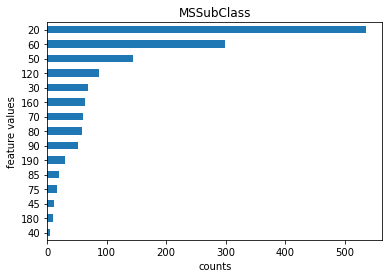

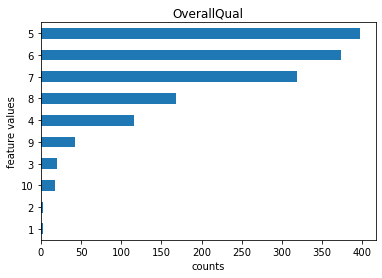

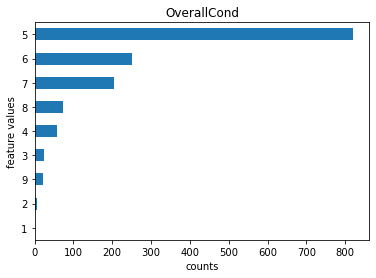

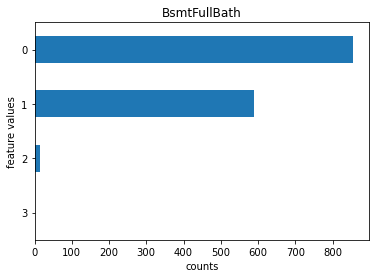

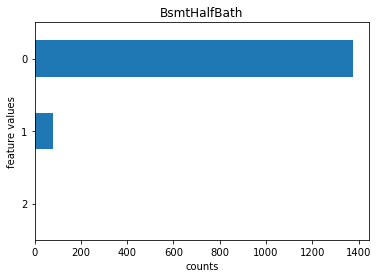

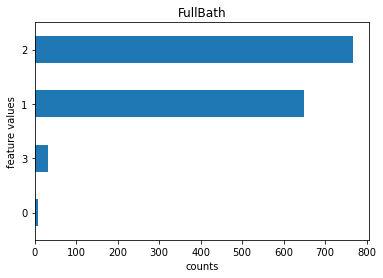

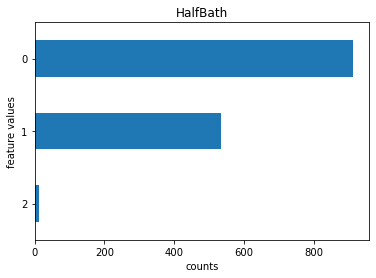

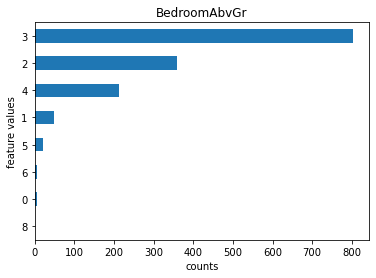

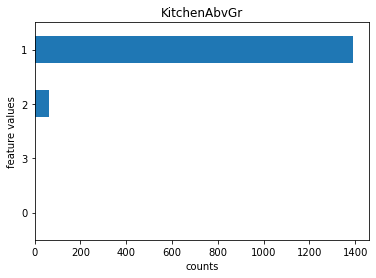

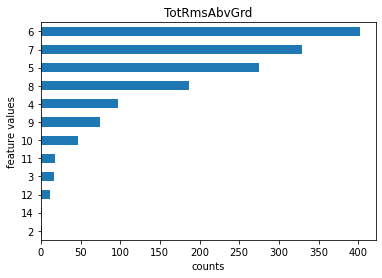

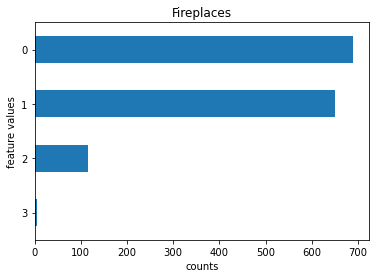

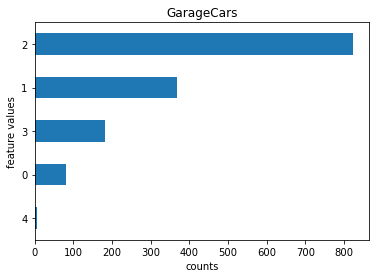

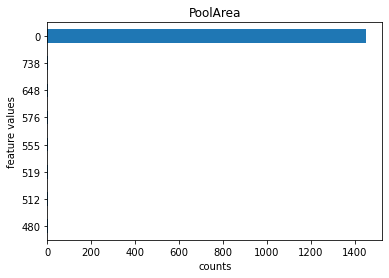

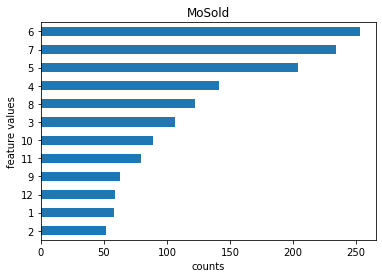

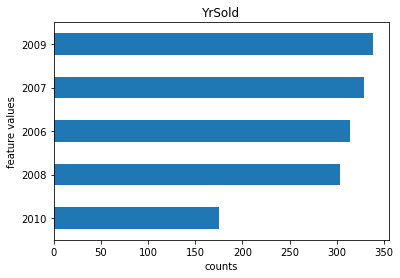

In [88]:
for feature in discrete_features:
    train_df[feature].value_counts().sort_values().plot(kind = 'barh')
    plt.xlabel('counts')
    plt.ylabel('feature values')
    plt.title(feature)
    plt.show()

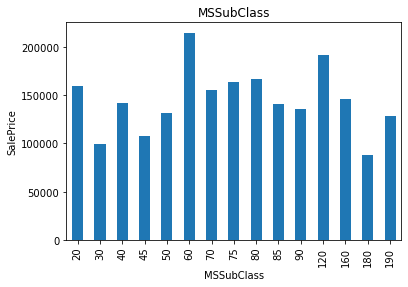

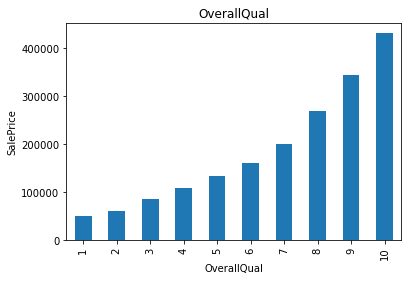

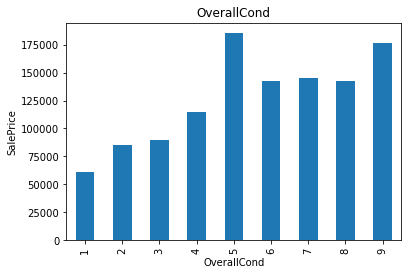

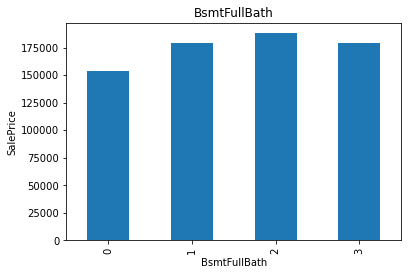

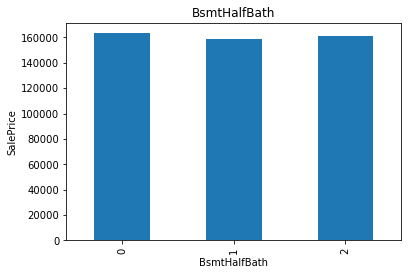

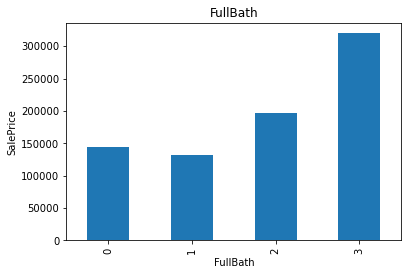

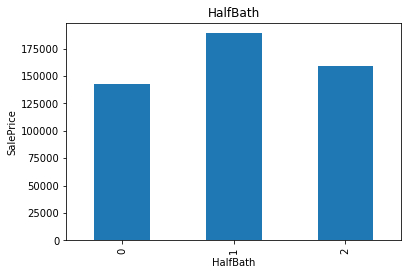

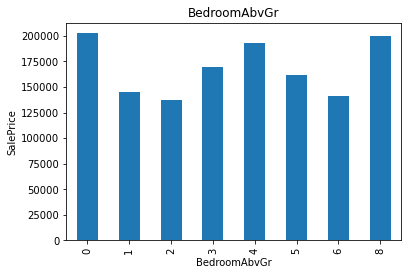

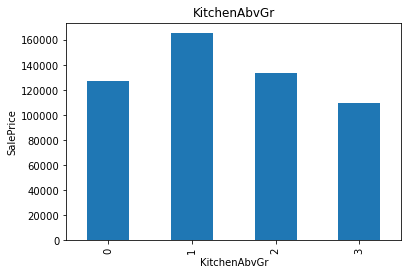

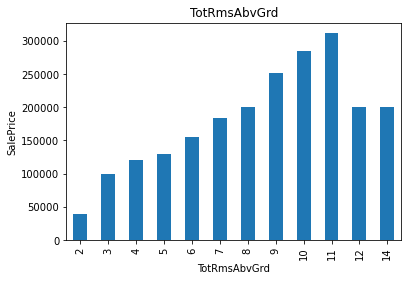

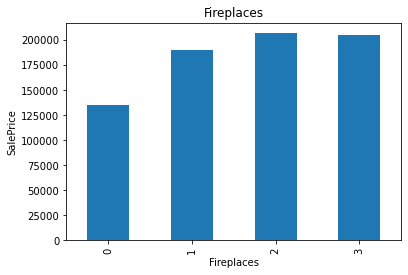

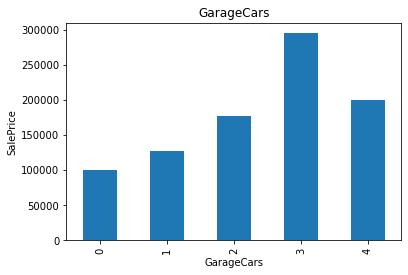

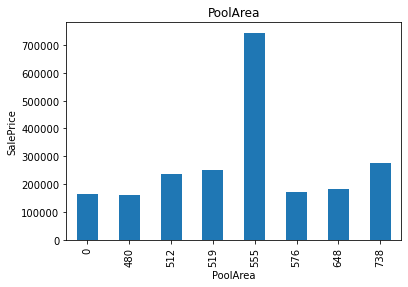

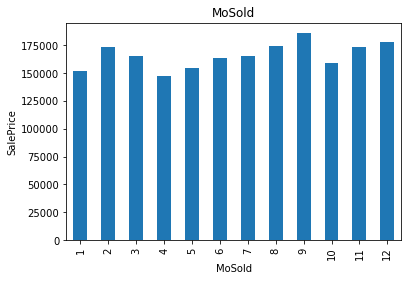

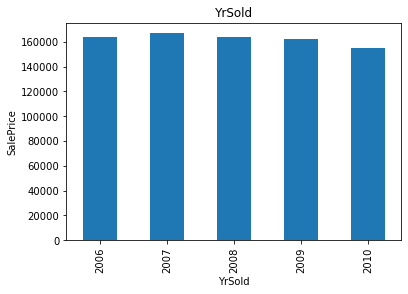

In [89]:
for feature in discrete_features:
    train_df.groupby(feature)['SalePrice'].median().plot.bar()
    plt.xlabel(feature)
    plt.ylabel('SalePrice')
    plt.title(feature)
    plt.show()

Some observations of the obtained plots:
* Most probably in all of the cases we can inpute the missing values with the mode (and there a very few, so probably not a big deal actually)
* Probably I should convert the very rare features into one 'other' category. Anyway, somehow have to handle those rare values.
* Maybe in some cases it has to be considered to make a binary variables from a categorical. For example: 1 HalfBath or Other; same with KitchenAbvGr; Pool / No pool (specially this last because as we can see on the graph above each enumeration are quite rare, expect of course 0).
* Some of them are actually not numeric data, they are rather strings, have to convert those: MSSubClass (regarding the documentation), YrSold, MoSold

## Categorical variables

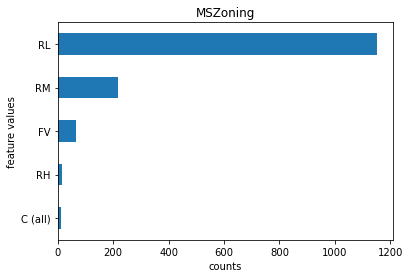

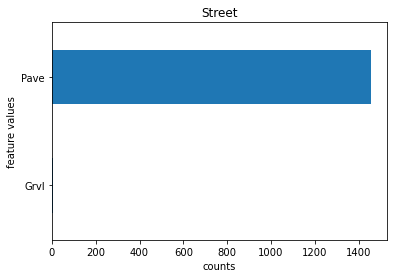

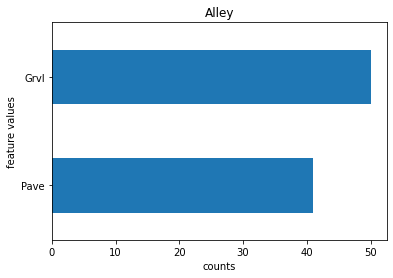

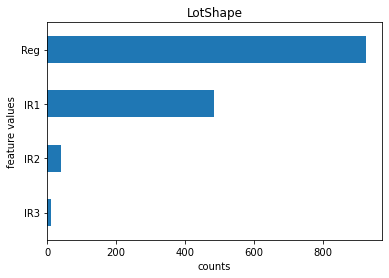

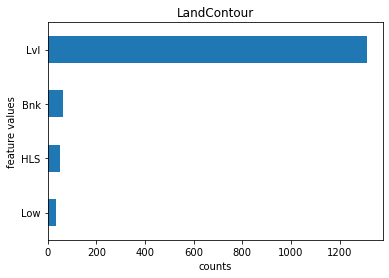

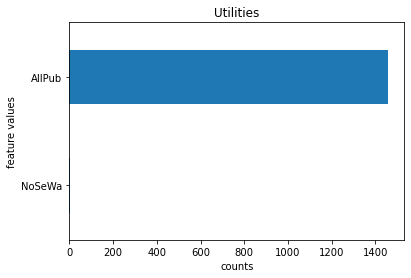

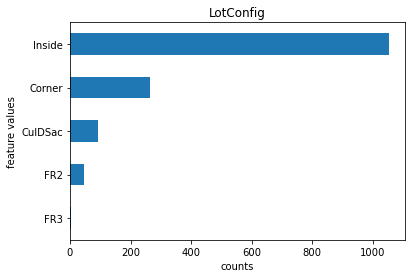

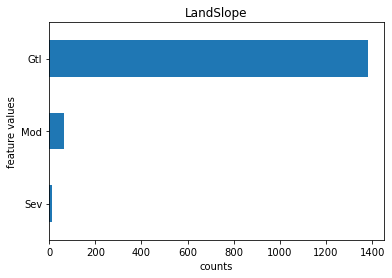

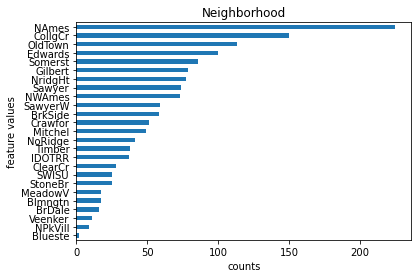

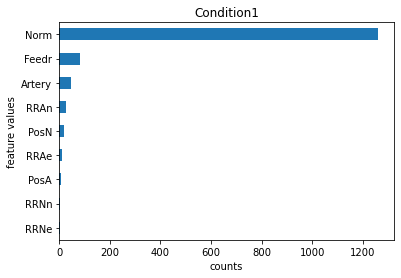

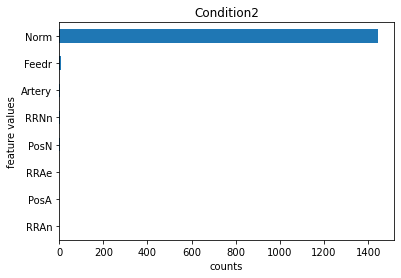

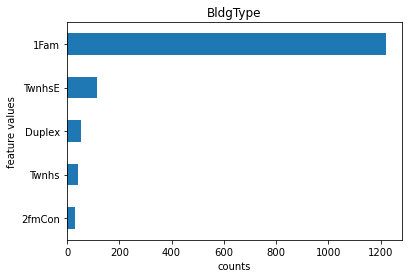

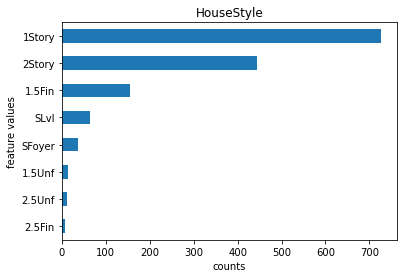

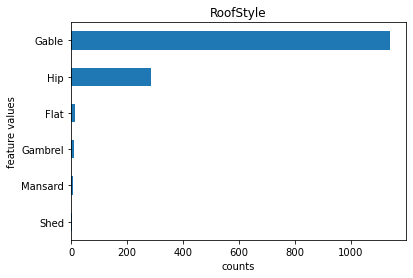

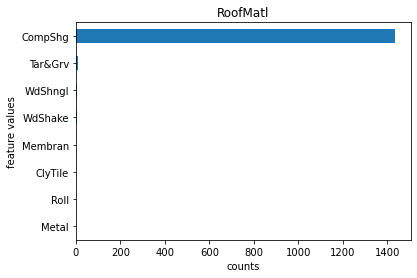

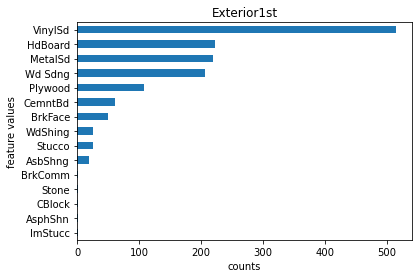

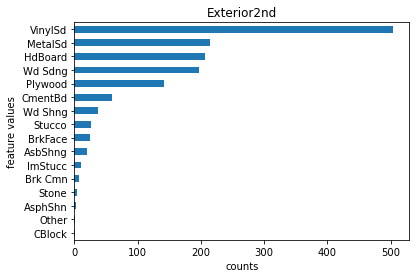

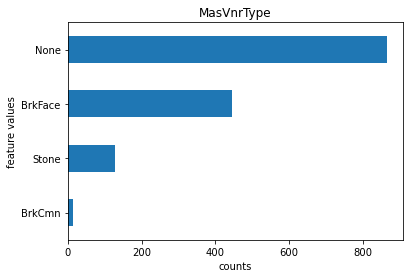

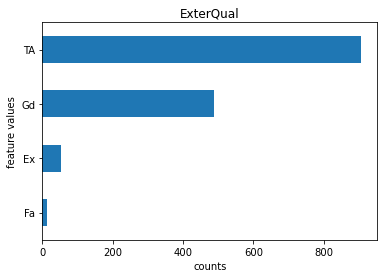

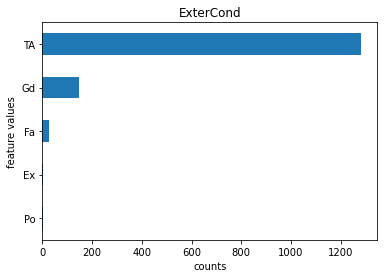

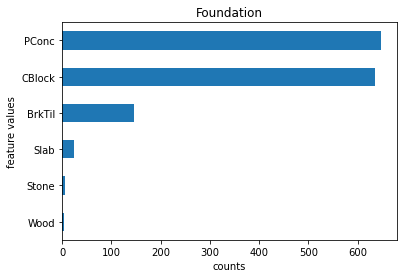

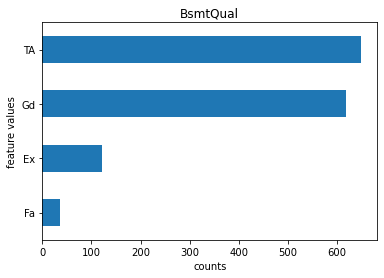

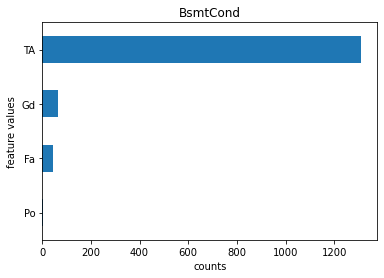

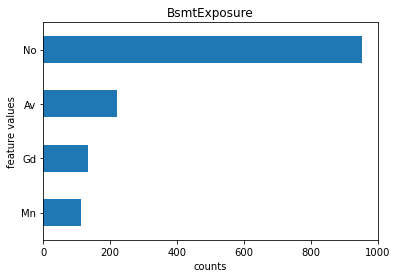

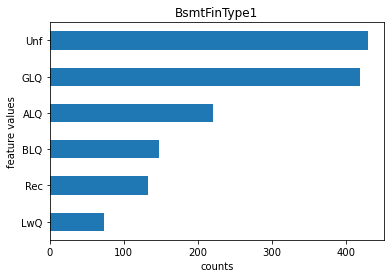

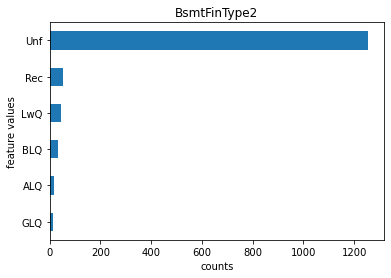

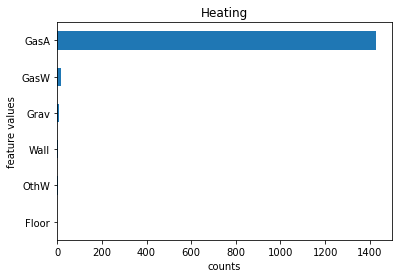

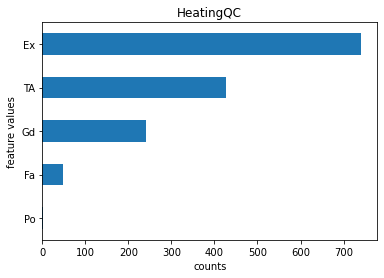

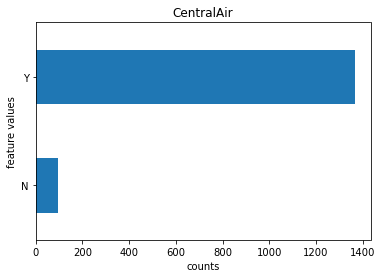

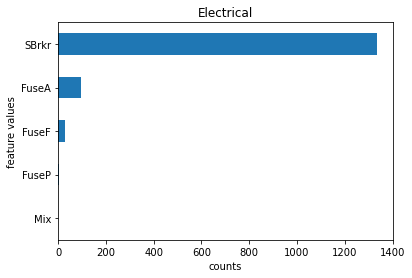

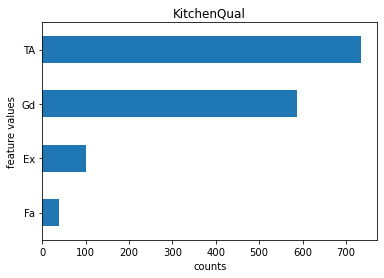

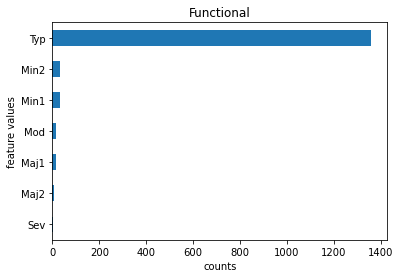

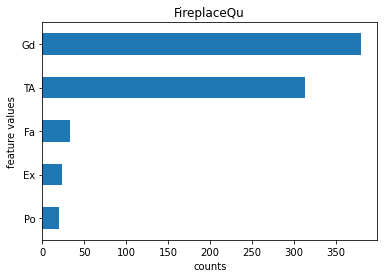

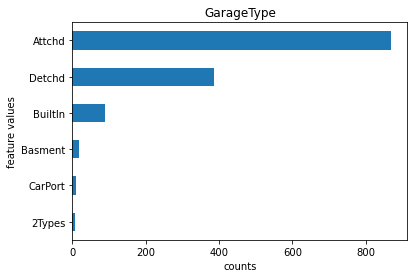

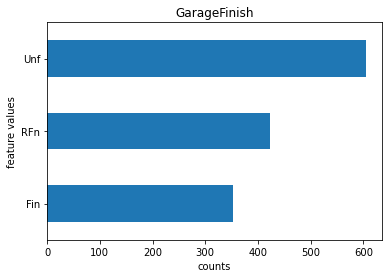

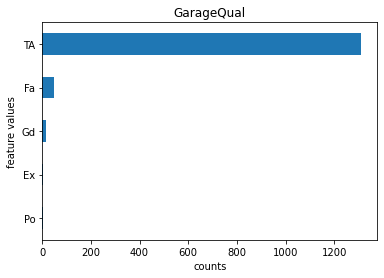

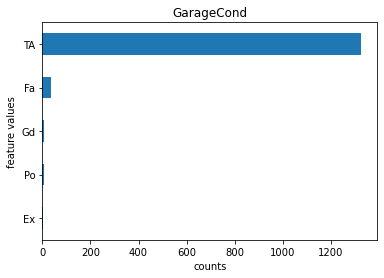

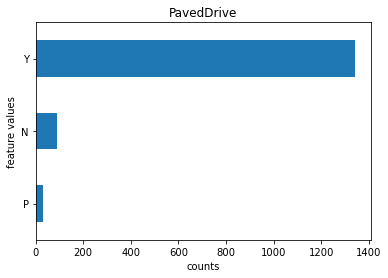

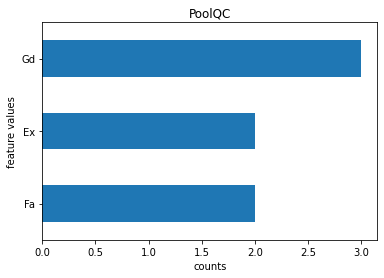

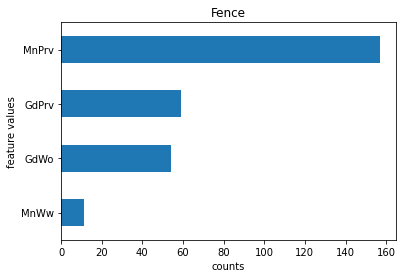

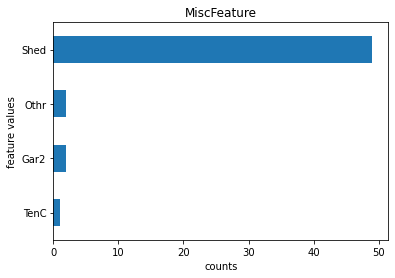

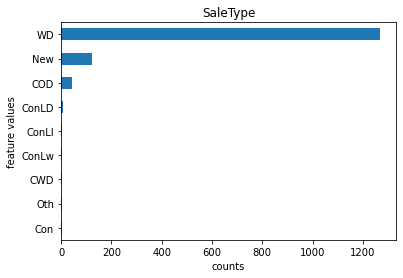

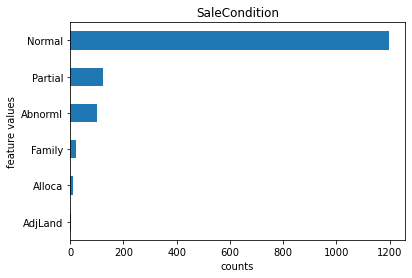

In [97]:
for feature in categorical_features:
    train_df[feature].value_counts().sort_values().plot(kind = 'barh')
    plt.xlabel('counts')
    plt.ylabel('feature values')
    plt.title(feature)
    plt.show()

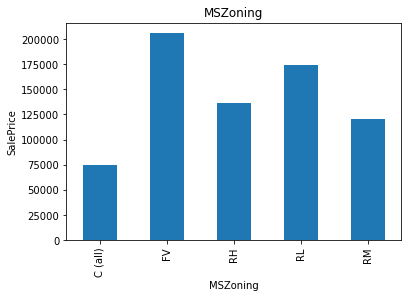

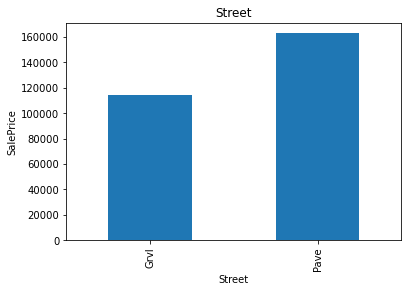

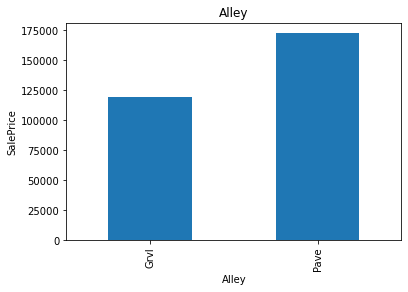

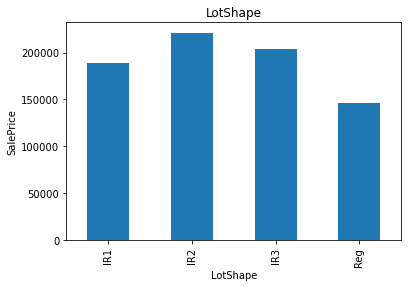

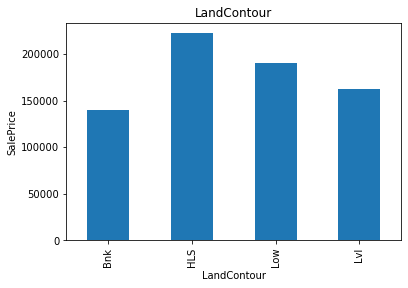

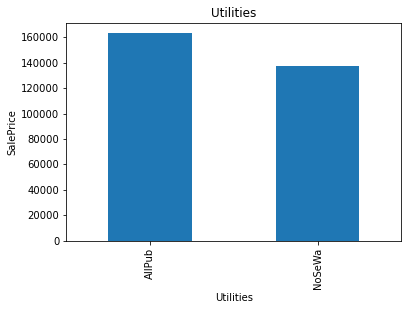

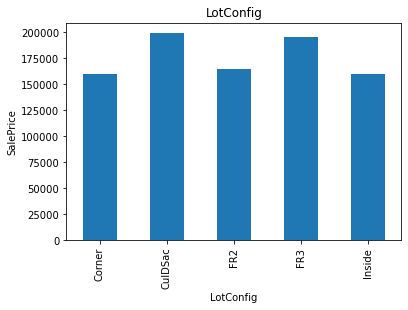

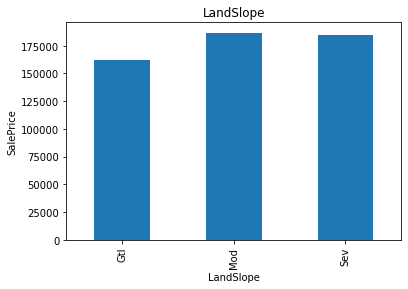

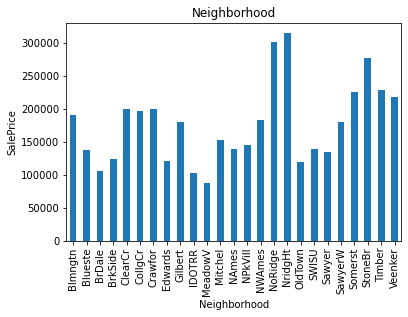

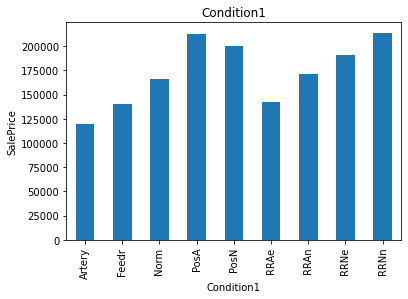

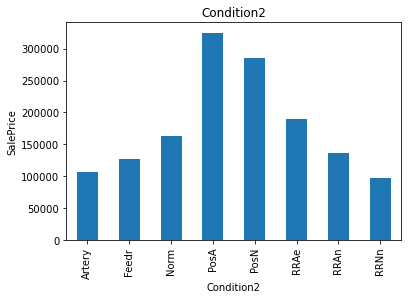

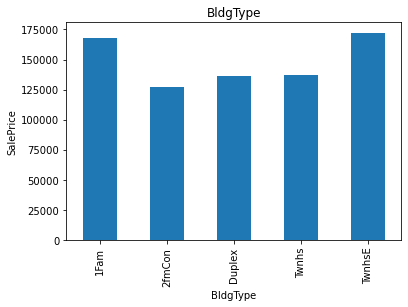

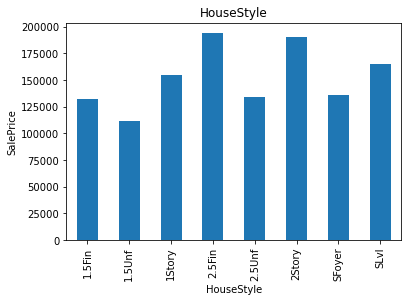

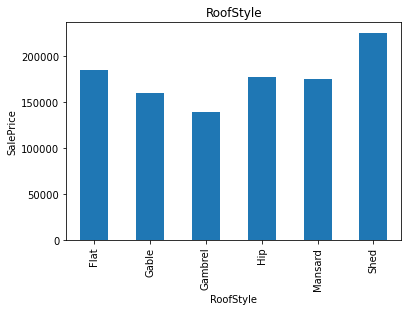

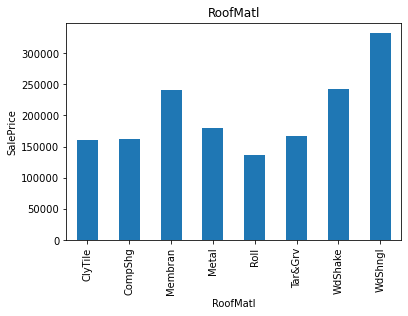

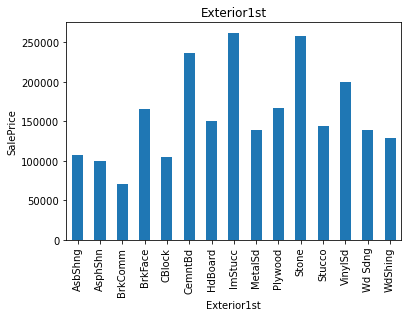

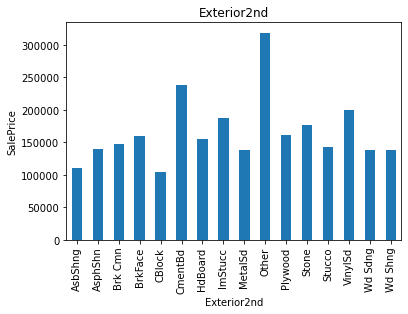

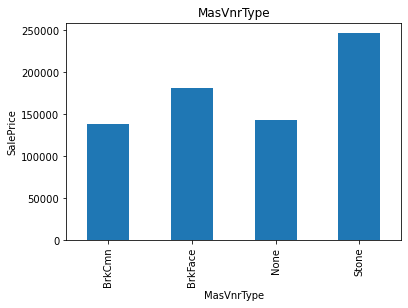

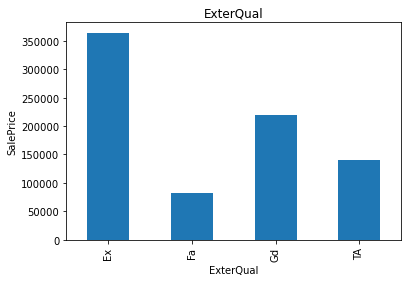

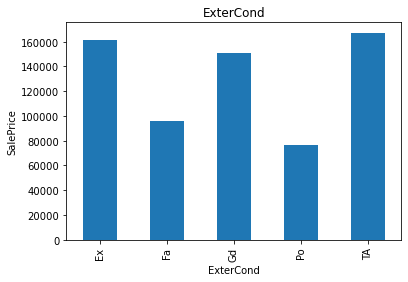

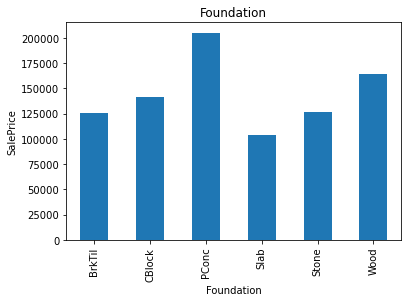

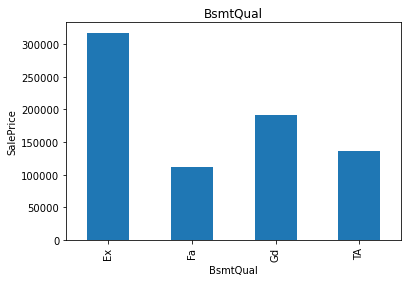

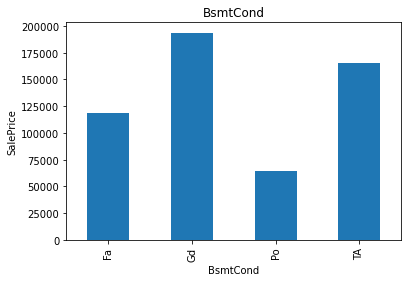

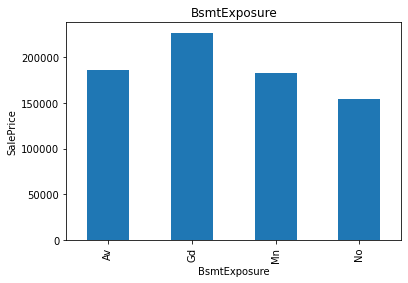

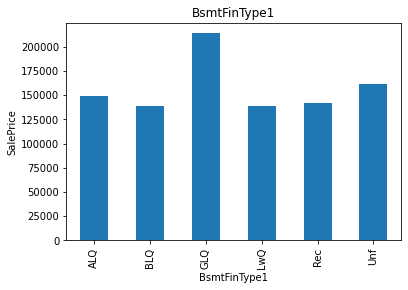

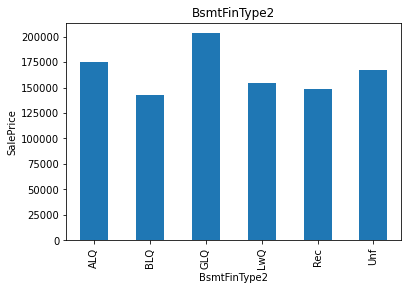

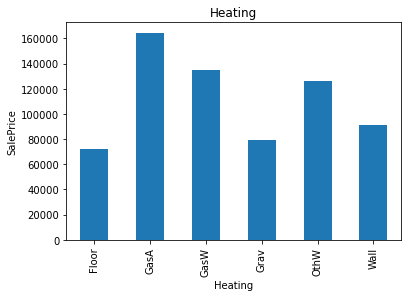

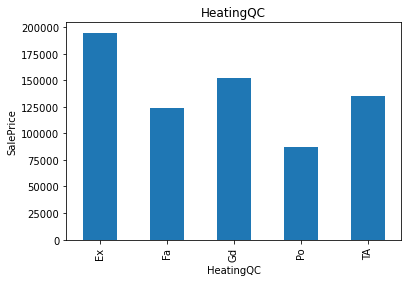

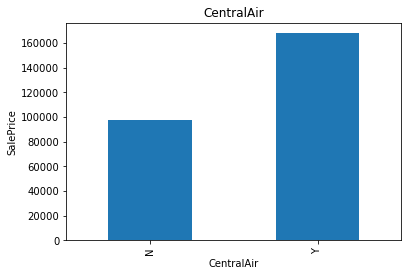

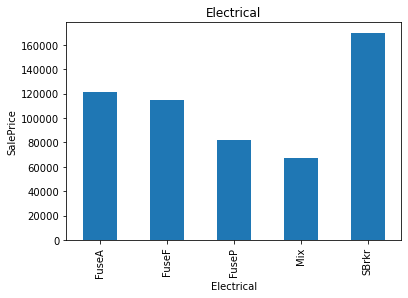

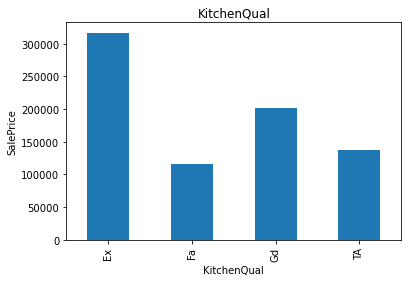

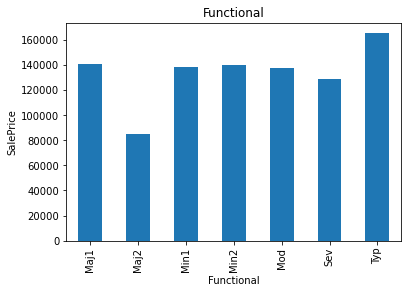

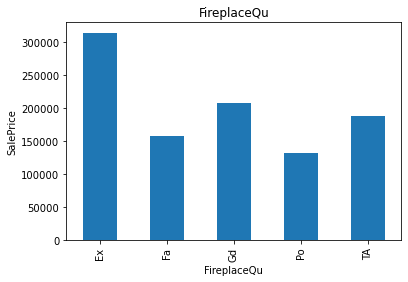

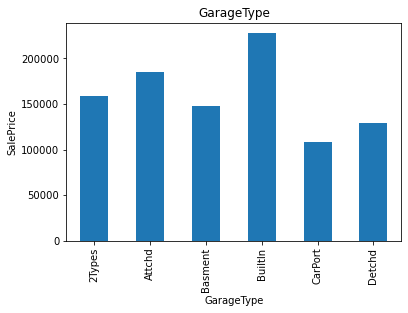

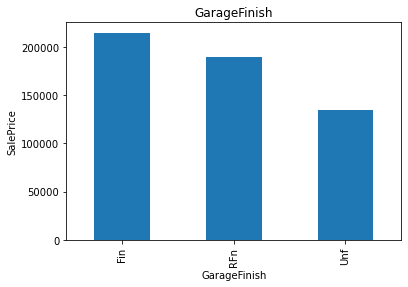

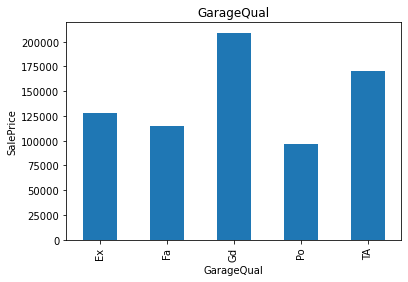

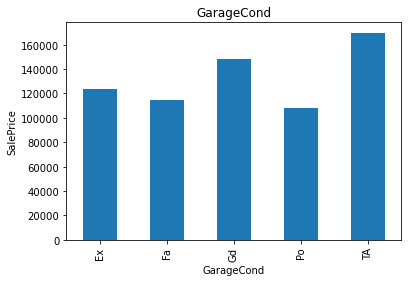

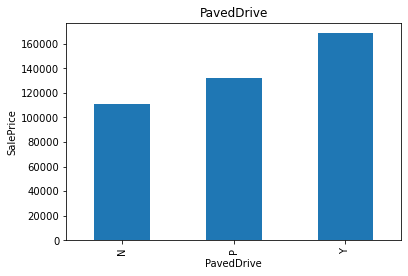

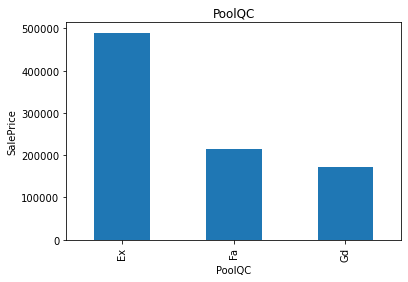

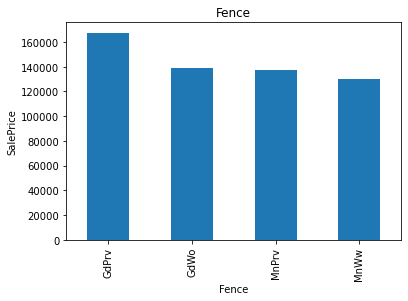

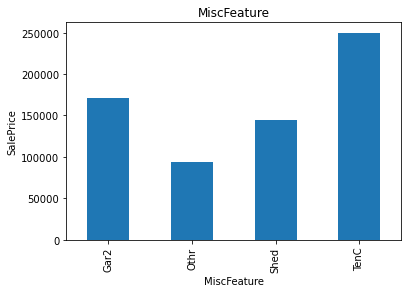

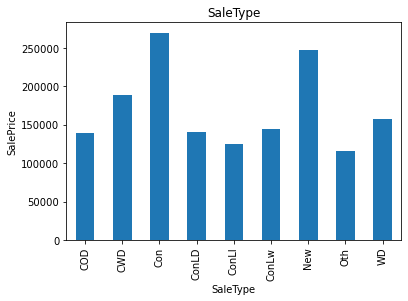

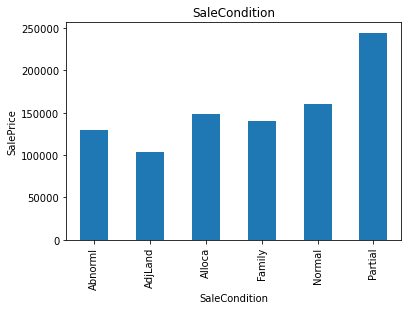

In [108]:
for feature in categorical_features:
    train_df.groupby(feature)['SalePrice'].median().plot.bar()
    plt.xlabel(feature)
    plt.ylabel('SalePrice')
    plt.title(feature)
    plt.show()

Some observations:
* There are some very rare features (enumerations in a specific feature), maybe I have to convert those into one 'Other' category.
* Maybe in the case of Condition2 it can be a binary (Normal / Not normal). 
* Same with RoofMatl.
* In BsmtCond we cannot really do that because as we on the graph above Good Basement condition indicates higher SalePrice.
* In Heating maybe we can convert into GasA / Other, since most of the observations are GasA and it indicates a higher SalePrice.
* Functional: Typical / Not typical.
* Regarding GarageQual we have to use one hot encoding (eventough it is a quality), because good indicates a higher SalePrice value than Excellent. This is mostly because there aren't many Excelent quality observation in the test set. Nevertheless I think it is a more safe choice.
* Same with GarageCond

In my opinion there are only very few cases where we can quite surely say that the categorical features are ordinal features. Hence I am going to use One Hot Encoding.

# Feature engineering

In this section I am going to work with the complete dataframe and then going to split again into the given train and test sets.

## Missing data and data cleaning

In [9]:
df.loc[df['GarageYrBlt']==2207.0, 'GarageYrBlt'] = 2007.0

Label the missing values and investigate the relations between the missing values and the response variable.

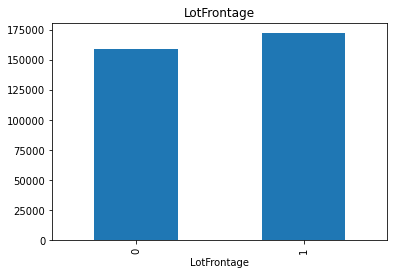

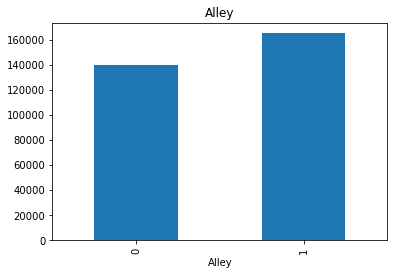

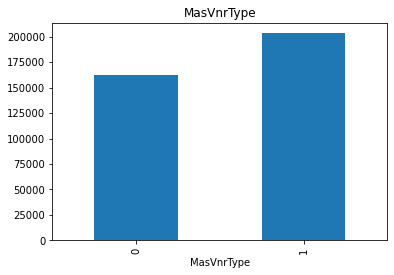

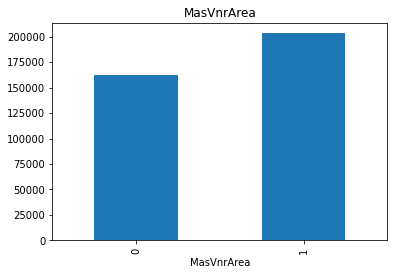

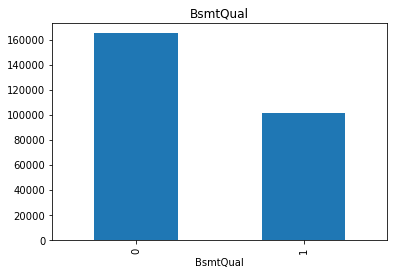

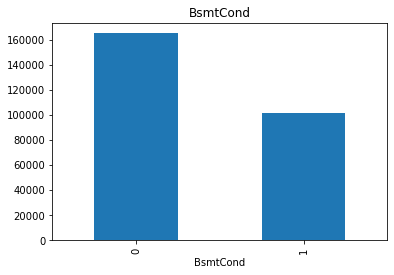

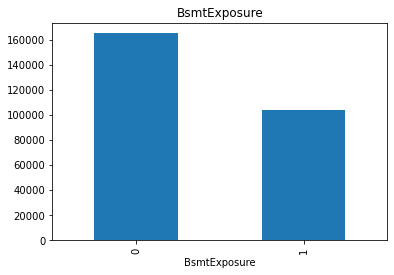

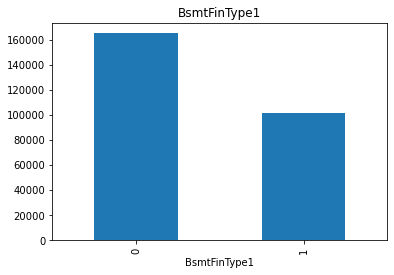

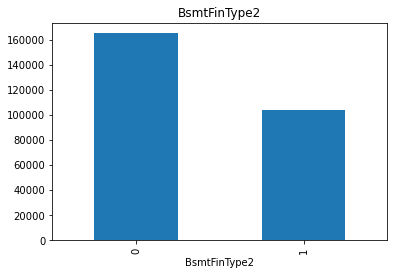

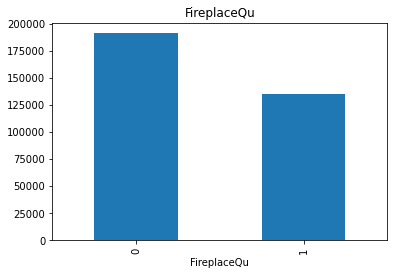

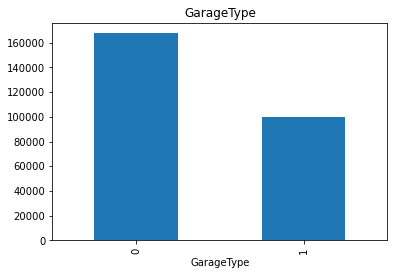

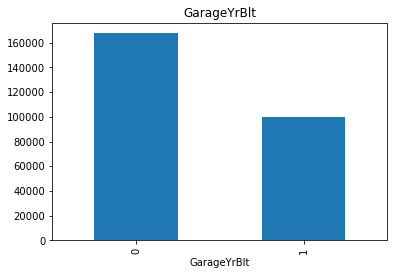

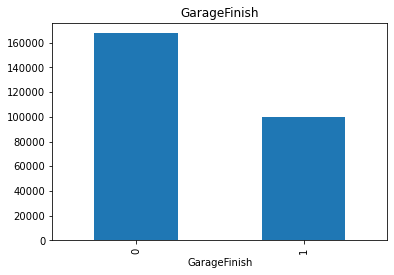

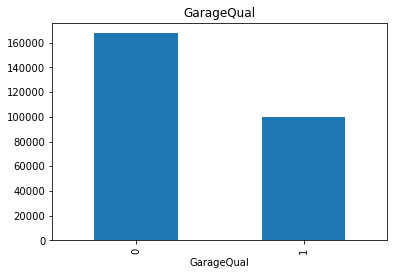

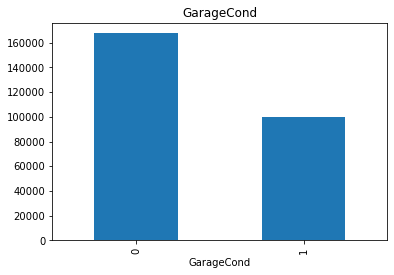

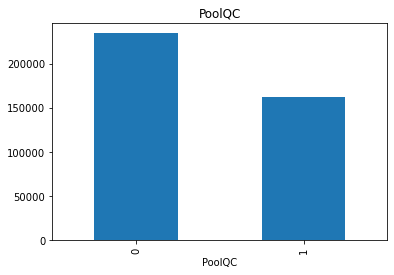

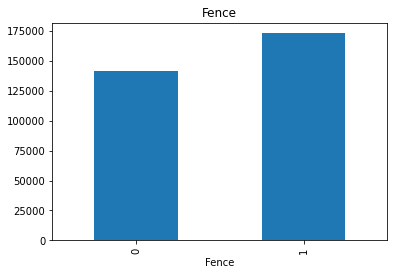

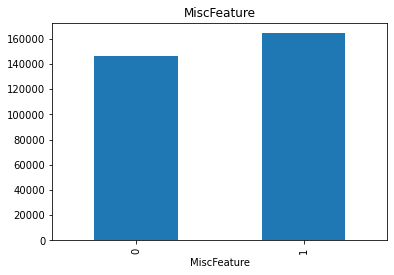

In [11]:
features_with_na=[features for features in train_df.columns if train_df[features].isnull().sum()>1]
for feature in features_with_na:
    train_copy = train_df.copy()
    train_copy[feature] = np.where(train_copy[feature].isnull(), 1, 0)
    train_copy.groupby(feature)['SalePrice'].median().plot.bar()
    plt.title(feature)
    plt.show()

Clearly strong relations in quite a few cases. Missing data imputation is very important in this project.

### Numerical missing data

In [10]:
numerical_with_nan = [feature for feature in df.columns if df[feature].isnull().sum()>0 and df[feature].dtypes!='O']
numerical_with_nan.remove('SalePrice')
numerical_with_nan

['LotFrontage',
 'MasVnrArea',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 'BsmtFullBath',
 'BsmtHalfBath',
 'GarageYrBlt',
 'GarageCars',
 'GarageArea']

If the GarageFinish missing it means No Garage according to the documentation. So we can impute this with 0.

In [11]:
for col in ['GarageYrBlt', 'GarageArea', 'GarageCars']:
    df[col] = df[col].fillna(0)

If BsmtFinType1 is missing it means that all the numeric basement related values are zero.

In [12]:
for col in ['BsmtFullBath', 'BsmtHalfBath', 'TotalBsmtSF', 'BsmtUnfSF', 'BsmtFinSF2', 'BsmtFinSF1']:
    df[col] = df[col].fillna(0)

In [14]:
df['LotFrontage'] = df.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))

In [15]:
df[['MasVnrArea', 'MasVnrType']][(df['MasVnrType']=='None') & (df['MasVnrArea']>0)]

,MasVnrArea,MasVnrType
624,288.0,None
773,1.0,None
1230,1.0,None
1300,344.0,None
1334,312.0,None
1669,285.0,None
2452,1.0,None


This is clearly an anomaly again. We do not have any evidence which one is incorrect, however my intuition is that it is more likely that MasVnrType (why would they give this numbers as area if there isn't). Let's change these values to BrkFace since this is the mode if we'd drop None (a graph few lines above shows that).

In [16]:
df.loc[(df['MasVnrType']=='None') & (df['MasVnrArea']>0), ['MasVnrType']] = 'BrkFace'

In [17]:
df[['MasVnrArea', 'MasVnrType']][(df['MasVnrType'].isnull()) & (df['MasVnrArea']>0)]

,MasVnrArea,MasVnrType
2610,198.0,NaN


Let's impute this with the corresponding mode. (Similar argument to the one few lines above.)

In [18]:
df.loc[(df['MasVnrType'].isnull()) & (df['MasVnrArea']>0), ['MasVnrType']] = 'BrkFace'

In [19]:
df[['MasVnrArea', 'MasVnrType']][(df['MasVnrType']!='None') & (df['MasVnrArea']==0)]

,MasVnrArea,MasVnrType
688,0.0,BrkFace
1241,0.0,Stone
2319,0.0,BrkFace


This is again a bad situation, we can see an anomaly in the data, but we do not have any clue which ones are incorrect. My choice is arbitrary. I am going to impute with the corresponding medians.

In [20]:
df.loc[(df['MasVnrType']!='None') & (df['MasVnrArea']==0), ['MasVnrArea']] = df.loc[(df['MasVnrType']!='None') & (df['MasVnrArea']>0), ['MasVnrArea']].median()[0]

In [21]:
df[['MasVnrArea', 'MasVnrType']][df['MasVnrType'].isnull()]

,MasVnrArea,MasVnrType
234,NaN,NaN
529,NaN,NaN
650,NaN,NaN
936,NaN,NaN
973,NaN,NaN
977,NaN,NaN
1243,NaN,NaN
1278,NaN,NaN
1691,NaN,NaN
1706,NaN,NaN


I am going to impute these with 0 and 'None' since these are the most common values and it is consequent. What is not so good that most of the missing values are in the test set.

In [22]:
df['MasVnrArea'] = df['MasVnrArea'].fillna(0)
df['MasVnrType'] = df['MasVnrType'].fillna('None')

In [23]:
numerical_with_nan = [feature for feature in df.columns if df[feature].isnull().sum()>0 and df[feature].dtypes!='O']
numerical_with_nan.remove('SalePrice')
numerical_with_nan
# just to check...

[]

### Categorical missing data

In some of the cases we can rely on the documentation. In other cases I am going to impute the missing data based on the corresponding mode.

In [24]:
categorical_with_nan = [feature for feature in df.columns if df[feature].isnull().sum()>0 and df[feature].dtypes=='O']
categorical_with_nan

['MSZoning',
 'Alley',
 'Utilities',
 'Exterior1st',
 'Exterior2nd',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'Electrical',
 'KitchenQual',
 'Functional',
 'FireplaceQu',
 'GarageType',
 'GarageFinish',
 'GarageQual',
 'GarageCond',
 'PoolQC',
 'Fence',
 'MiscFeature',
 'SaleType']

In [25]:
df['Alley'] = df['Alley'].fillna('None')
df['FireplaceQu'] = df['FireplaceQu'].fillna('None')
df['MiscFeature'] = df['MiscFeature'].fillna('None')
df['Fence'] = df['Fence'].fillna('None')
df['Utilities'] = df['Utilities'].fillna(df['Utilities'].mode()[0])
df['Functional'] = df['Functional'].fillna('Typ')
df['Electrical'] = df['Electrical'].fillna(df['Electrical'].mode()[0])
df['KitchenQual'] = df['KitchenQual'].fillna(df['KitchenQual'].mode()[0])
df['Exterior1st'] = df['Exterior1st'].fillna(df['Exterior1st'].mode()[0])
df['Exterior2nd'] = df['Exterior2nd'].fillna(df['Exterior2nd'].mode()[0])
df['SaleType'] = df['SaleType'].fillna(df['SaleType'].mode()[0])
df['MSZoning'] = df['MSZoning'].fillna(df['MSZoning'].mode()[0])
df["PoolQC"] = df["PoolQC"].fillna("None")
df['GarageType'] = df['GarageType'].fillna('None')
df['GarageFinish'] = df['GarageFinish'].fillna('None')
df['GarageQual'] = df['GarageQual'].fillna('None')
df['GarageCond'] = df['GarageCond'].fillna('None')
df['BsmtQual'] = df['BsmtQual'].fillna('None')
df['BsmtCond'] = df['BsmtCond'].fillna('None')
df['BsmtExposure'] = df['BsmtExposure'].fillna('None')
df['BsmtFinType1'] = df['BsmtFinType1'].fillna('None')
df['BsmtFinType2'] = df['BsmtFinType2'].fillna('None')

In [26]:
[feature for feature in df.columns if df[feature].isnull().sum()>0]
# imputed all missing values in the predictors

['SalePrice']

### Dates

Substract the value from the corresponding year sold date to provide more information for the model.

In [27]:
for feature in ['YearBuilt','YearRemodAdd','GarageYrBlt']: 
    df[feature]=df['YrSold']-df[feature]

### Numerical to string

As I obtained in the beginning of the notebook all of the discrete features stored as numbers however some of them are actually strings according to the documentation. I convert these into the appropriate data type. This is important because we cannot define an order, they not ordinal variables. Some graphs show that above where I plotted the SalePrice againts the discrete features' enumerations. Hence I am going to use one hot encoding in these cases too.

In [28]:
df['MSSubClass'] = df['MSSubClass'].apply(str)
df['YrSold'] = df['YrSold'].astype(str)
df['MoSold'] = df['MoSold'].astype(str)

### Creating new features

I mentioned a few examples earlier based on the graphs I obtained during the EDA. Here I am going to do these 'transformations'. The goal here is create new variables which are quite clear for humans and maybe the model can benefit from these. Some of the derived features based on other people's notebooks, but intuition is always clearly visible in the plots I obtained in the EDA (histograms and barplots).

In [29]:
df['haspool'] = df['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
df['has2ndfloor'] = df['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
df['hasgarage'] = df['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
df['hasbasement'] = df['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
df['hasfireplace'] = df['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)
df['hasopenporch'] = df['OpenPorchSF'].apply(lambda x: 1 if x > 0 else 0)
df['hasclosedporch'] = df['EnclosedPorch'].apply(lambda x: 1 if x > 0 else 0)
df['has3snporch'] = df['3SsnPorch'].apply(lambda x: 1 if x > 0 else 0)
df['hasscreenporch'] = df['ScreenPorch'].apply(lambda x: 1 if x > 0 else 0)
df['TotalSF'] = df['TotalBsmtSF'] + df['1stFlrSF'] + df['2ndFlrSF']
df['Total_Bathrooms'] = (df['FullBath'] + (0.5 * df['HalfBath']) + df['BsmtFullBath'] + (0.5 * df['BsmtHalfBath']))

### Outliers

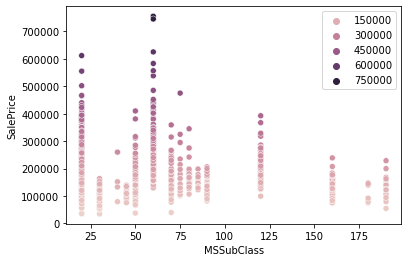

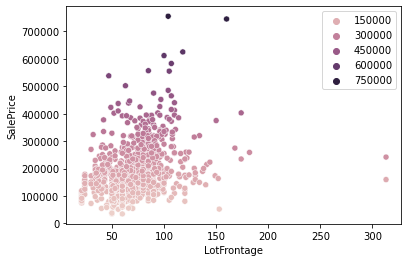

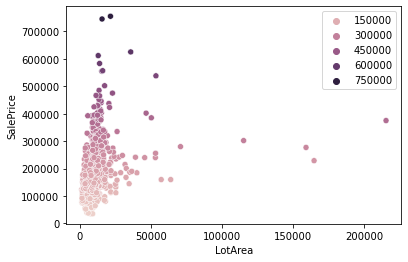

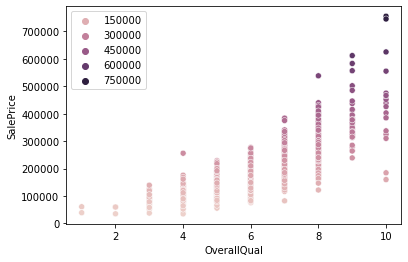

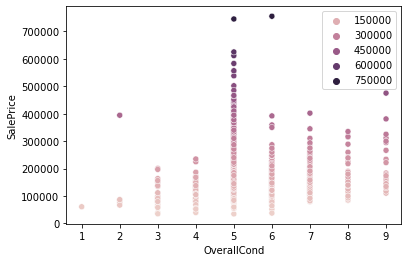

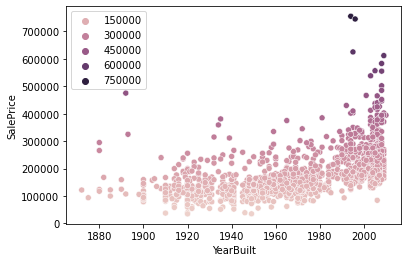

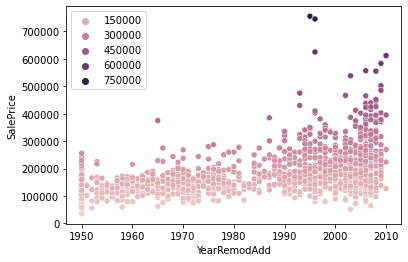

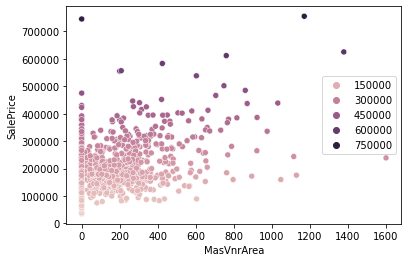

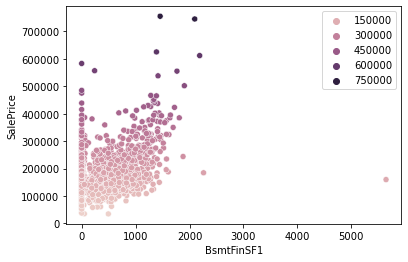

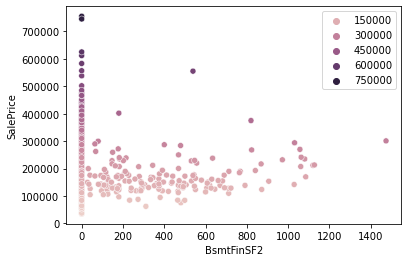

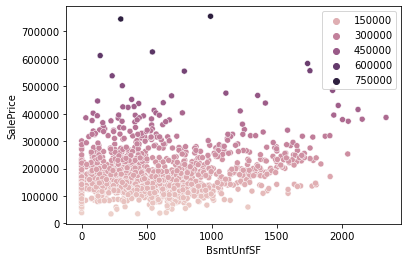

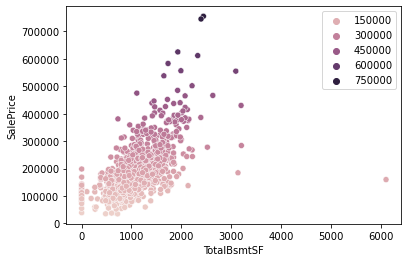

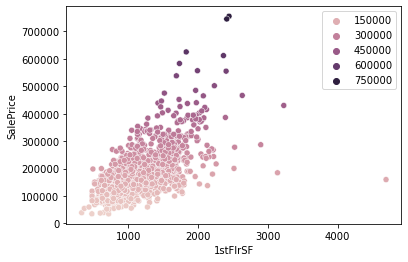

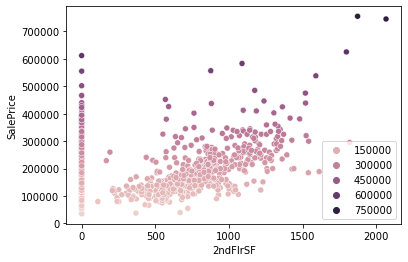

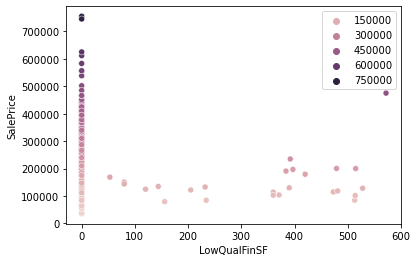

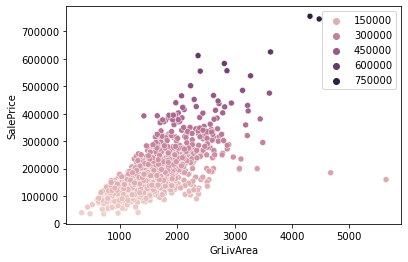

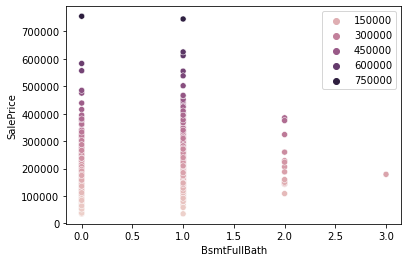

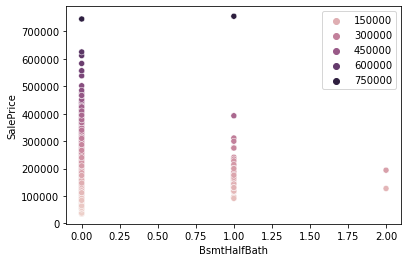

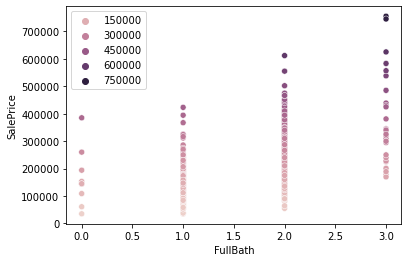

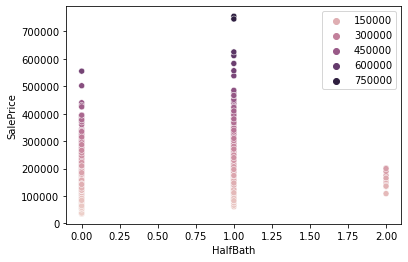

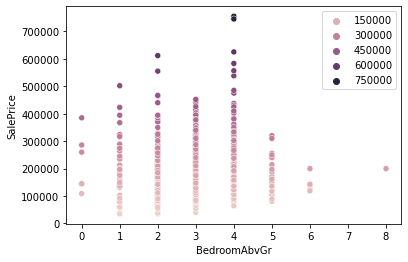

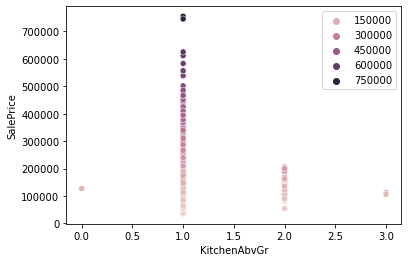

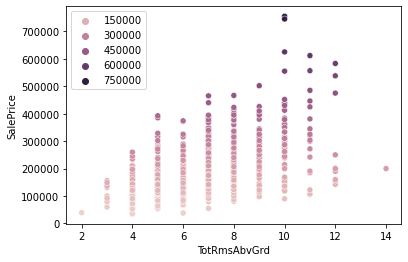

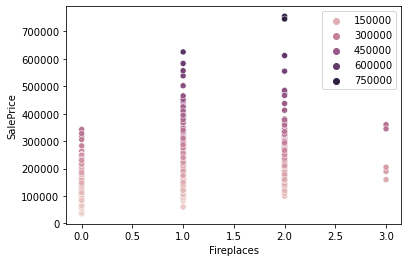

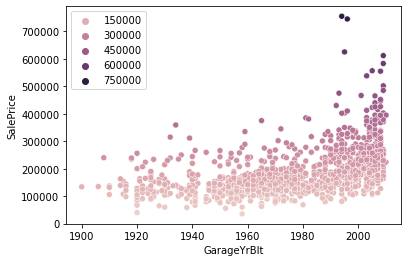

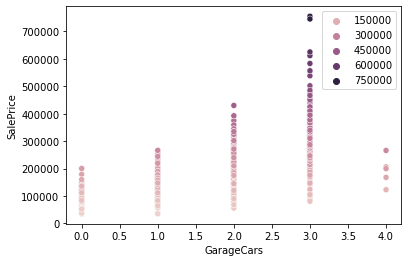

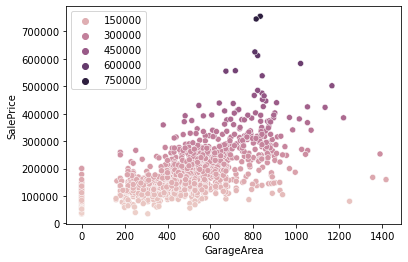

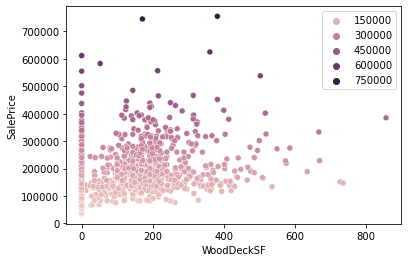

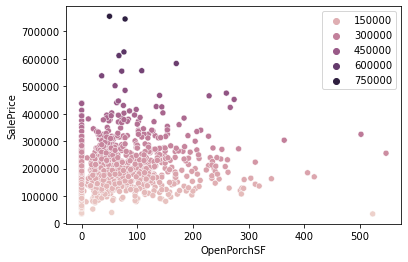

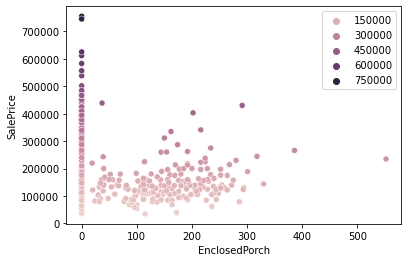

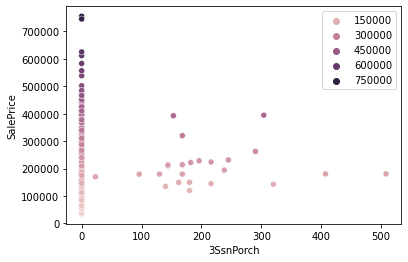

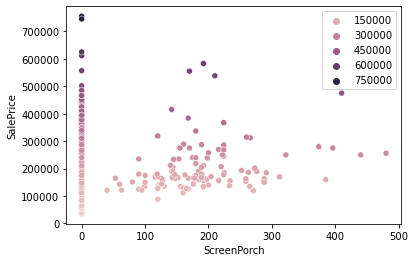

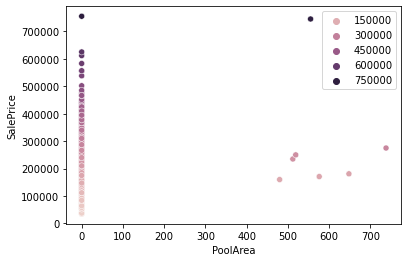

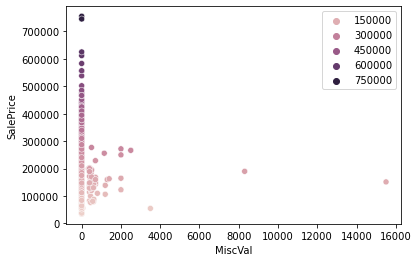

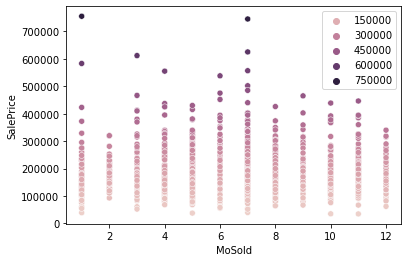

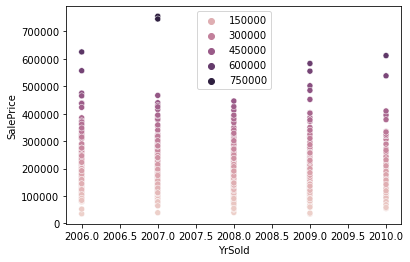

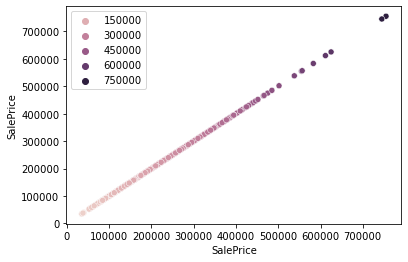

In [174]:
for feature in numerical_features:
    sns.pairplot(df[])
    plt.xlabel(feature)
    plt.ylabel('SalePrice')
    plt.legend(loc='best', prop={'size': 10})
    plt.show()

We can observe some outliers in the plots above. I am going to investigate them with some queries.

In [193]:
train_df[(train_df['GrLivArea']>4000) & (train_df['SalePrice']<300000)]

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
523,60,RL,130.0,40094,Pave,NaN,IR1,Bnk,AllPub,Inside,Gtl,Edwards,PosN,PosN,1Fam,2Story,10,5,2007,2008,Hip,CompShg,CemntBd,CmentBd,Stone,762.0,Ex,TA,PConc,Ex,TA,Gd,GLQ,2260,Unf,0,878,3138,GasA,Ex,Y,SBrkr,3138,1538,0,4676,1,0,3,1,3,1,Ex,11,Typ,1,Gd,BuiltIn,2007.0,Fin,3,884,TA,TA,Y,208,406,0,0,0,0,NaN,NaN,NaN,0,10,2007,New,Partial,184750
1298,60,RL,313.0,63887,Pave,NaN,IR3,Bnk,AllPub,Corner,Gtl,Edwards,Feedr,Norm,1Fam,2Story,10,5,2008,2008,Hip,ClyTile,Stucco,Stucco,Stone,796.0,Ex,TA,PConc,Ex,TA,Gd,GLQ,5644,Unf,0,466,6110,GasA,Ex,Y,SBrkr,4692,950,0,5642,2,0,2,1,3,1,Ex,12,Typ,3,Gd,Attchd,2008.0,Fin,2,1418,TA,TA,Y,214,292,0,0,0,480,Gd,NaN,NaN,0,1,2008,New,Partial,160000


In [181]:
train_df[train_df['TotalBsmtSF']>5000]
# the same I obtained

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
1298,60,RL,313.0,63887,Pave,NaN,IR3,Bnk,AllPub,Corner,Gtl,Edwards,Feedr,Norm,1Fam,2Story,10,5,2008,2008,Hip,ClyTile,Stucco,Stucco,Stone,796.0,Ex,TA,PConc,Ex,TA,Gd,GLQ,5644,Unf,0,466,6110,GasA,Ex,Y,SBrkr,4692,950,0,5642,2,0,2,1,3,1,Ex,12,Typ,3,Gd,Attchd,2008.0,Fin,2,1418,TA,TA,Y,214,292,0,0,0,480,Gd,NaN,NaN,0,1,2008,New,Partial,160000


In [195]:
train_df[(train_df['GarageArea']>1200) & (train_df['SalePrice']<200000)]

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
1061,30,C (all),120.0,18000,Grvl,NaN,Reg,Low,AllPub,Inside,Gtl,IDOTRR,Norm,Norm,1Fam,1Story,3,4,1935,1950,Gable,CompShg,MetalSd,MetalSd,None,0.0,Fa,TA,CBlock,TA,TA,No,Unf,0,Unf,0,894,894,GasA,TA,Y,SBrkr,894,0,0,894,0,0,1,0,2,1,TA,6,Typ,0,NaN,Detchd,1994.0,RFn,3,1248,TA,TA,Y,0,20,0,0,0,0,NaN,NaN,Shed,560,8,2008,ConLD,Normal,81000
1190,190,RL,NaN,32463,Pave,NaN,Reg,Low,AllPub,Inside,Mod,Mitchel,Norm,Norm,2fmCon,1Story,4,4,1961,1975,Gable,CompShg,MetalSd,MetalSd,Stone,149.0,TA,Gd,CBlock,TA,TA,Av,BLQ,1159,Unf,0,90,1249,GasA,Ex,Y,SBrkr,1622,0,0,1622,1,0,1,0,3,1,TA,7,Typ,1,TA,2Types,1975.0,Fin,4,1356,TA,TA,Y,439,0,0,0,0,0,NaN,NaN,NaN,0,3,2007,WD,Normal,168000
1298,60,RL,313.0,63887,Pave,NaN,IR3,Bnk,AllPub,Corner,Gtl,Edwards,Feedr,Norm,1Fam,2Story,10,5,2008,2008,Hip,ClyTile,Stucco,Stucco,Stone,796.0,Ex,TA,PConc,Ex,TA,Gd,GLQ,5644,Unf,0,466,6110,GasA,Ex,Y,SBrkr,4692,950,0,5642,2,0,2,1,3,1,Ex,12,Typ,3,Gd,Attchd,2008.0,Fin,2,1418,TA,TA,Y,214,292,0,0,0,480,Gd,NaN,NaN,0,1,2008,New,Partial,160000


In [186]:
train_df[(train_df['1stFlrSF']>3000) & (train_df['SalePrice']<200000)]

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
523,60,RL,130.0,40094,Pave,NaN,IR1,Bnk,AllPub,Inside,Gtl,Edwards,PosN,PosN,1Fam,2Story,10,5,2007,2008,Hip,CompShg,CemntBd,CmentBd,Stone,762.0,Ex,TA,PConc,Ex,TA,Gd,GLQ,2260,Unf,0,878,3138,GasA,Ex,Y,SBrkr,3138,1538,0,4676,1,0,3,1,3,1,Ex,11,Typ,1,Gd,BuiltIn,2007.0,Fin,3,884,TA,TA,Y,208,406,0,0,0,0,NaN,NaN,NaN,0,10,2007,New,Partial,184750
1298,60,RL,313.0,63887,Pave,NaN,IR3,Bnk,AllPub,Corner,Gtl,Edwards,Feedr,Norm,1Fam,2Story,10,5,2008,2008,Hip,ClyTile,Stucco,Stucco,Stone,796.0,Ex,TA,PConc,Ex,TA,Gd,GLQ,5644,Unf,0,466,6110,GasA,Ex,Y,SBrkr,4692,950,0,5642,2,0,2,1,3,1,Ex,12,Typ,3,Gd,Attchd,2008.0,Fin,2,1418,TA,TA,Y,214,292,0,0,0,480,Gd,NaN,NaN,0,1,2008,New,Partial,160000


In [188]:
train_df[train_df['MasVnrArea']>1500]

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
297,60,FV,66.0,7399,Pave,Pave,IR1,Lvl,AllPub,Inside,Gtl,Somerst,Norm,Norm,1Fam,2Story,7,5,1997,1998,Hip,CompShg,VinylSd,VinylSd,BrkFace,1600.0,Gd,TA,PConc,Gd,TA,No,BLQ,649,Unf,0,326,975,GasA,Ex,Y,SBrkr,975,975,0,1950,0,0,2,1,3,1,Gd,7,Typ,1,TA,Detchd,1997.0,RFn,2,576,TA,TA,Y,0,10,0,0,198,0,NaN,NaN,NaN,0,6,2007,WD,Normal,239000


In [189]:
train_df[train_df['LotArea']>200000]

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
313,20,RL,150.0,215245,Pave,NaN,IR3,Low,AllPub,Inside,Sev,Timber,Norm,Norm,1Fam,1Story,7,5,1965,1965,Hip,CompShg,BrkFace,BrkFace,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,1236,Rec,820,80,2136,GasW,TA,Y,SBrkr,2036,0,0,2036,2,0,2,0,3,1,TA,8,Typ,2,Gd,Attchd,1965.0,RFn,2,513,TA,TA,Y,0,0,0,0,0,0,NaN,NaN,NaN,0,6,2009,WD,Normal,375000


Let's remove these observations from the training set.

In [37]:
train_df[(train_df['OverallCond']==2) & (train_df['SalePrice']>100000)]

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
378,20,RL,88.0,11394,Pave,NaN,Reg,Lvl,AllPub,Corner,Gtl,StoneBr,Norm,Norm,1Fam,1Story,9,2,2010,2010,Hip,CompShg,VinylSd,VinylSd,Stone,350.0,Gd,TA,PConc,Ex,TA,Av,GLQ,1445,Unf,0,411,1856,GasA,Ex,Y,SBrkr,1856,0,0,1856,1,0,1,1,1,1,Ex,8,Typ,1,Ex,Attchd,2010.0,Fin,3,834,TA,TA,Y,113,0,0,0,0,0,NaN,NaN,NaN,0,6,2010,New,Partial,394432


In [38]:
outliers = [523, 1298, 1061, 1190, 297, 313, 378]
df = df.drop(df.index[outliers])

### Encoding

As I mentioned previously we do not have any evidence to threat the categorical variables as ordinal variables, so I am going to use the one hot encoding technique. In addition I did some experiments. Based on other notebooks I tried label encoding in the following way: first order each enumeration in the categorical columns by the mean of the response variable and then based on that order each enumeration. With this we do not obtain so many features. On the other hand the one hot encoded way outperformed the label encoder way (in my experiments).

In [39]:
for_dummies = [feature for feature in df.columns if df[feature].dtype=='O']
df = pd.get_dummies(df, prefix = for_dummies, columns = for_dummies)

# Applied ML models

## Final preparation

Everytime I drop an observation the indexing is messed up in the pandas dataframe and sk-learn cannot handle it. I know that the following chunk is a mess, but that's how it worked... After that I made a logtransformation on the response variable in the train set and split that into train and validation sets.

In [105]:
df = df.reset_index(drop=True)
df.to_csv("df_prep.csv", index=False)
df = pd.read_csv('df_prep.csv')
train_df = df.iloc[:len(train_df)-7, :]
test_df = df.iloc[len(train_df)-7:, :]
df = df.reset_index(drop=True)
df.to_csv("df_prep.csv", index=False)
train_df = df.iloc[:len(train_df), :]
test_df = df.iloc[len(train_df):, :]

The description on Kaggle says that the evaluation is performed on the logarithm of the prediction and the logarithm of the target.

In [106]:
train_df["SalePrice"] = np.log(train_df["SalePrice"])

In [58]:
X_train = train_df.drop(['SalePrice'], axis=1)
y_train = train_df['SalePrice']
# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)

In [59]:
X_t, X_val, y_t, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=1)

## Learning curve

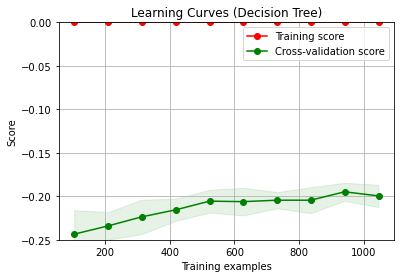

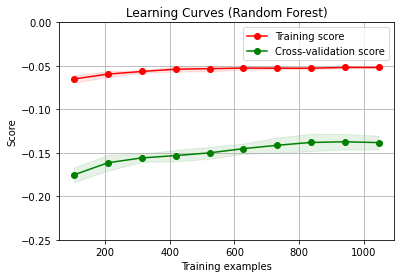

In [364]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 10)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring='neg_root_mean_squared_error')
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")
    plt.legend(loc="best")
    return plt

title = "Learning Curves (Decision Tree)"
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
estimator = make_pipeline(StandardScaler(), DecisionTreeRegressor(random_state=1))
plot_learning_curve(estimator, title, X_t, y_t, ylim=(-0.25, 0), cv=cv, n_jobs=4)

title = "Learning Curves (Random Forest)"
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
estimator = make_pipeline(StandardScaler(), RandomForestRegressor(random_state=1))
plot_learning_curve(estimator, title, X_t, y_t, (-0.25, 0), cv=cv)
plt.show()

The Random Forest outperform the Decision tree on the validation set. Interestingly the optimal train-test split seems quite similar in both cases. If we'd make the test splits based on the plots I'd choose 60-40 split. However I did some experiments and obtained pretty similar results when I choose 90-10 split. I will go with that because we can train our model on a larger the dataset because the test set is quite large.

In [60]:
X_t, X_val, y_t, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=1)

## Tree based methods

In [51]:
def search_results_optuna(study):
    unnecessary = ['number', 'datetime_start', 'datetime_complete', 'duration', 'state']
    results = study.trials_dataframe()
    for col in unnecessary:
        results.drop([col], axis=1, inplace=True)
    results.sort_values(by='value', ascending=False, inplace=True)
    return results

### Decision tree

I did some experiments and find the Standard Scaler the best. Also did some experiments to include PCA in the pipeline (since I have quite a few features) but it was better not to.

In [61]:
def tree_objective(trial):
    model = make_pipeline(
        StandardScaler(),
        DecisionTreeRegressor(
            min_samples_split = trial.suggest_float('min_samples_split', 2/X_t.shape[0], 0.4),
            criterion = trial.suggest_categorical('criterion', ['squared_error', 'friedman_mse', 'absolute_error', 'poisson']),
            min_samples_leaf = trial.suggest_float('min_samples_leaf', 1/X_t.shape[0], 0.5),
            random_state=1,
            ccp_alpha = trial.suggest_float('ccp_alpha', 0.0, 0.02),
            max_depth = trial.suggest_int('max_depth', 2, 80),
            max_features = trial.suggest_int('max_features', 1, 100)
        )
    )
    scores = cross_val_score(model, X_t, y_t, scoring='neg_root_mean_squared_error', cv=KFold(n_splits=5,shuffle=True,random_state=1))
    return scores.mean()

tree_study = optuna.create_study(
    direction="maximize",
)

tree_study.optimize(tree_objective, n_trials=30)

[I 2022-08-08 21:18:59,937] A new study created in memory with name: no-name-16bfcb2e-70dc-42f9-878b-4322a44a0863
[I 2022-08-08 21:19:00,103] Trial 0 finished with value: -0.4041666544332787 and parameters: {'min_samples_split': 0.013144902641794663, 'criterion': 'poisson', 'min_samples_leaf': 0.3291162927435279, 'ccp_alpha': 0.004453659342041485, 'max_depth': 17, 'max_features': 10}. Best is trial 0 with value: -0.4041666544332787.
[I 2022-08-08 21:19:00,247] Trial 1 finished with value: -0.3029202958119358 and parameters: {'min_samples_split': 0.1290429984703073, 'criterion': 'friedman_mse', 'min_samples_leaf': 0.18640045378002626, 'ccp_alpha': 0.015934009500434682, 'max_depth': 14, 'max_features': 64}. Best is trial 1 with value: -0.3029202958119358.
[I 2022-08-08 21:19:00,398] Trial 2 finished with value: -0.3067145058456564 and parameters: {'min_samples_split': 0.16836443055070782, 'criterion': 'friedman_mse', 'min_samples_leaf': 0.06911929066985716, 'ccp_alpha': 0.014334698037165

In [63]:
search_results_optuna(tree_study).head(5)

,value,params_ccp_alpha,params_criterion,params_max_depth,params_max_features,params_min_samples_leaf,params_min_samples_split
28,-0.230494,0.000974,squared_error,25,72,0.042957,0.202903
26,-0.231271,0.004111,absolute_error,65,79,0.051437,0.130604
16,-0.232831,0.007214,absolute_error,49,85,0.012309,0.096014
29,-0.233264,0.000884,squared_error,23,70,0.048377,0.194339
21,-0.236284,0.008710,absolute_error,49,100,0.023834,0.048729


Consider this the 'best' model with a decision tree approach.

In [64]:
decisiontreeregressor = DecisionTreeRegressor(
    min_samples_split = tree_study.best_params['min_samples_split'],
    min_samples_leaf = tree_study.best_params['min_samples_leaf'],
    max_features = tree_study.best_params['max_features'],
    ccp_alpha = tree_study.best_params['ccp_alpha'],
    max_depth = tree_study.best_params['max_depth'],
    criterion = tree_study.best_params['criterion'],
    random_state=1)
decisiontreeregressor.fit(X_t.values, y_t)
y_train_pred = decisiontreeregressor.predict(X_t.values)
y_pred = decisiontreeregressor.predict(X_val.values)
print('Train RMSE: ', mean_squared_error(y_t, y_train_pred, squared=False))
print('Test RMSE: ', mean_squared_error(y_val, y_pred, squared=False))

Train RMSE:  0.24022009777575434
Test RMSE:  0.23019798210666334


### Random Forest

In [69]:
def rf_objective(trial):
    model = RandomForestRegressor(
        min_samples_split = trial.suggest_float('min_samples_split', 2/X_t.shape[0], 0.4),
        criterion = trial.suggest_categorical('criterion', ['squared_error', 'absolute_error', 'poisson']),
        max_features = trial.suggest_int('max_features', 1, 100),
        n_estimators = trial.suggest_int('n_estimators', 70, 200),
        min_samples_leaf = trial.suggest_float('min_samples_leaf', 1/X_train.shape[0], 0.01),
        random_state=1,
        max_depth = trial.suggest_int('max_depth', 2, 80))
    scores = cross_val_score(model, X_t, y_t, scoring='neg_root_mean_squared_error', cv=KFold(n_splits=5,shuffle=True,random_state=1))
    return scores.mean()

rf_study = optuna.create_study(
    direction="maximize",
)

rf_study.optimize(rf_objective, n_trials=10)

[I 2022-08-08 21:45:22,089] A new study created in memory with name: no-name-adbf0469-a38c-4ae6-b870-76769f8f4de0
[I 2022-08-08 21:45:52,070] Trial 0 finished with value: -0.15680087012418933 and parameters: {'min_samples_split': 0.04219324263557744, 'criterion': 'absolute_error', 'max_features': 100, 'n_estimators': 120, 'min_samples_leaf': 0.009279627346209263, 'max_depth': 24}. Best is trial 0 with value: -0.15680087012418933.
[I 2022-08-08 21:45:53,399] Trial 1 finished with value: -0.2578965325917667 and parameters: {'min_samples_split': 0.34700868721824485, 'criterion': 'squared_error', 'max_features': 30, 'n_estimators': 181, 'min_samples_leaf': 0.007919706011031641, 'max_depth': 31}. Best is trial 0 with value: -0.15680087012418933.
[I 2022-08-08 21:46:08,620] Trial 2 finished with value: -0.22696478442601958 and parameters: {'min_samples_split': 0.24630639090890746, 'criterion': 'absolute_error', 'max_features': 70, 'n_estimators': 117, 'min_samples_leaf': 0.006613739472403084

In [70]:
randomforestregressor = RandomForestRegressor(
    min_samples_split = rf_study.best_params['min_samples_split'],
    criterion = rf_study.best_params['criterion'],
    min_samples_leaf = rf_study.best_params['min_samples_leaf'],
    max_features = rf_study.best_params['max_features'],
    max_depth = rf_study.best_params['max_depth'],
    n_estimators = rf_study.best_params['n_estimators'],
    random_state=1)
randomforestregressor.fit(X_t.values, y_t)
y_train_pred = randomforestregressor.predict(X_t.values)
y_pred = randomforestregressor.predict(X_val.values)
print('Train RMSE: ', mean_squared_error(y_t, y_train_pred, squared=False))
print('Test RMSE: ', mean_squared_error(y_val, y_pred, squared=False))

Train RMSE:  0.14542481729641354
Test RMSE:  0.13124515506790635


That's not a bad improvement comparing to the decision tree approach. Let's try another iteration based on the results.

In [103]:
def rf_objective(trial):
    model = RandomForestRegressor(
        min_samples_split = trial.suggest_float('min_samples_split', 2/X_t.shape[0], 0.4),
        criterion = trial.suggest_categorical('criterion', ['squared_error', 'absolute_error', 'poisson']),
        max_features = trial.suggest_int('max_features', 1, 100),
        n_estimators = trial.suggest_int('n_estimators', 70, 200),
        min_samples_leaf = trial.suggest_float('min_samples_leaf', 1/X_train.shape[0], 0.01),
        random_state=1,
        max_depth = trial.suggest_int('max_depth', 2, 80))
    scores = cross_val_score(model, X_t, y_t, scoring='neg_root_mean_squared_error', cv=KFold(n_splits=5,shuffle=True,random_state=1))
    return scores.mean()

rf_study = optuna.create_study(
    direction="maximize",
)

rf_study.optimize(rf_objective, n_trials=10)

[I 2022-08-08 22:29:53,965] A new study created in memory with name: no-name-a966ec51-f9b4-4a49-97b3-279a441c7f48
[I 2022-08-08 22:30:00,748] Trial 0 finished with value: -0.21118549600324027 and parameters: {'min_samples_split': 0.15319663306056186, 'criterion': 'absolute_error', 'max_features': 20, 'n_estimators': 100, 'min_samples_leaf': 0.00078182043032948, 'max_depth': 58}. Best is trial 0 with value: -0.21118549600324027.
[I 2022-08-08 22:30:08,896] Trial 1 finished with value: -0.15867894090833493 and parameters: {'min_samples_split': 0.025466106513646506, 'criterion': 'absolute_error', 'max_features': 35, 'n_estimators': 76, 'min_samples_leaf': 0.007691543453140154, 'max_depth': 59}. Best is trial 1 with value: -0.15867894090833493.
[I 2022-08-08 22:30:09,537] Trial 2 finished with value: -0.2413861551329631 and parameters: {'min_samples_split': 0.30210922670973217, 'criterion': 'squared_error', 'max_features': 30, 'n_estimators': 79, 'min_samples_leaf': 0.009759162946276793, '

## Random Forest submission

The best obtained tree based model:

In [86]:
X_test = randomforestregressor.drop(['SalePrice'], axis=1)
y_test = randomforestregressor['SalePrice']
y_test_pred = randomforestregressor.predict(X_test.values)

In [87]:
submission = pd.read_csv('sample_submission.csv')
submission.drop(['SalePrice'], axis=1, inplace=True)
submission['SalePrice'] = y_test_pred
submission.iloc[:,1] = np.expm1(y_test_pred) # transform back
submission.to_csv('submission_rf.csv', index=False)

This is my best tree-based result. Score on Kaggle: 0.15367 <br> <br>
Brief summary:
* 90-10 train-validation split worked better than 60-40
* one hot encoding was better than label encoding (all other thing were pretty much the same)
* random forest outperformed decision tree

## Non-tree-based method

### Lasso

In [107]:
df = pd.read_csv('df_prep.csv')
train_df = df.iloc[:len(train_df)-7, :]
test_df = df.iloc[len(train_df)-7:, :]
df = df.reset_index(drop=True)
df.to_csv("df_prep.csv", index=False)
train_df = df.iloc[:len(train_df), :]
test_df = df.iloc[len(train_df):, :]

In [ ]:
continuous_features.remove('SalePrice')

In [109]:
for feature in continuous_features:
    df[feature] = np.log1p(df[feature])

In [110]:
df = df.reset_index(drop=True)
train_df = df.iloc[:len(train_df), :]
test_df = df.iloc[len(train_df):, :]

In [112]:
train_df["SalePrice"] = np.log(train_df["SalePrice"])

In [113]:
X_train = train_df.drop(['SalePrice'], axis=1)
y_train = train_df['SalePrice']
# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)

X_t, X_val, y_t, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=1)

Based on my experiments Standard Scaler is a bit better choice than the Robust Scaler if we use the Lasso approach.

In [114]:
def lasso_objective(trial):
    model = make_pipeline(
        StandardScaler(),
        Lasso(
            alpha = trial.suggest_float('alpha', 0.0, 1.0),
            warm_start = trial.suggest_categorical('warm_start', [True, False]),
            selection = trial.suggest_categorical('selection', ['cyclic', 'random']),
            random_state=1
        )
    )
    scores = cross_val_score(model, X_t, y_t, scoring='neg_root_mean_squared_error', cv=KFold(n_splits=5,shuffle=True,random_state=1))
    return scores.mean()

lasso_study = optuna.create_study(
    direction="maximize",
)

lasso_study.optimize(lasso_objective, n_trials=40)

[I 2022-08-08 22:45:57,132] A new study created in memory with name: no-name-79ee8db5-0fac-4c2c-b10f-6bcdb62b8e81
[I 2022-08-08 22:45:57,317] Trial 0 finished with value: -0.40044891114120584 and parameters: {'alpha': 0.5011431983309913, 'warm_start': False, 'selection': 'random'}. Best is trial 0 with value: -0.40044891114120584.
[I 2022-08-08 22:45:57,494] Trial 1 finished with value: -0.40044891114120584 and parameters: {'alpha': 0.5453571655386521, 'warm_start': True, 'selection': 'cyclic'}. Best is trial 0 with value: -0.40044891114120584.
[I 2022-08-08 22:45:57,674] Trial 2 finished with value: -0.29376760059592255 and parameters: {'alpha': 0.21512696765058292, 'warm_start': False, 'selection': 'random'}. Best is trial 2 with value: -0.29376760059592255.
[I 2022-08-08 22:45:57,874] Trial 3 finished with value: -0.17406623546288832 and parameters: {'alpha': 0.0647381296917452, 'warm_start': False, 'selection': 'cyclic'}. Best is trial 3 with value: -0.17406623546288832.
[I 2022-08

In [115]:
lasso = Lasso(
    alpha = lasso_study.best_params['alpha'],
    warm_start = lasso_study.best_params['warm_start'],
    selection = lasso_study.best_params['selection'],
    random_state=1)
scaler = StandardScaler()
pipe_lasso = make_pipeline(scaler, lasso)
pipe_lasso.fit(X_t.values, y_t)
y_train_pred = pipe_lasso.predict(X_t.values)
y_pred = pipe_lasso.predict(X_val.values)
print('Train RMSE: ', mean_squared_error(y_t, y_train_pred, squared=False))
print('Validation RMSE: ', mean_squared_error(y_val, y_pred, squared=False))

Train RMSE:  0.10114693066998563
Validation RMSE:  0.09589743649399006


Based on the train and validation RMSE the Lasso can outperform the random forest on the test set. Let's do another iteration.

In [116]:
search_results_optuna(lasso_study).head()

,value,params_alpha,params_selection,params_warm_start
31,-0.113044,0.005664,cyclic,True
20,-0.113874,0.006818,cyclic,True
24,-0.114833,0.001440,cyclic,True
35,-0.116279,0.000872,cyclic,True
12,-0.117096,0.009558,cyclic,True


This is somewhat surprising for me that it is almost the full least square model since the penalty term is almost 0.

In [117]:
def lasso_objective(trial):
    model = make_pipeline(
        StandardScaler(),
        Lasso(
            alpha = trial.suggest_float('alpha', 0.0, 0.01),
            warm_start = trial.suggest_categorical('warm_start', [True, False]),
            selection = trial.suggest_categorical('selection', ['cyclic', 'random']),
            random_state=1
        )
    )
    scores = cross_val_score(model, X_t, y_t, scoring='neg_root_mean_squared_error', cv=KFold(n_splits=5,shuffle=True,random_state=1))
    return scores.mean()

lasso_study = optuna.create_study(
    direction="maximize",
)

lasso_study.optimize(lasso_objective, n_trials=20)

[I 2022-08-08 22:47:10,838] A new study created in memory with name: no-name-d9ff7241-cd3e-4745-bbf5-a183dda59968
[I 2022-08-08 22:47:11,100] Trial 0 finished with value: -0.11330435752276084 and parameters: {'alpha': 0.0060991904985528604, 'warm_start': True, 'selection': 'random'}. Best is trial 0 with value: -0.11330435752276084.
[I 2022-08-08 22:47:11,343] Trial 1 finished with value: -0.11387047848471084 and parameters: {'alpha': 0.006805654833696182, 'warm_start': True, 'selection': 'random'}. Best is trial 0 with value: -0.11330435752276084.
[I 2022-08-08 22:47:11,624] Trial 2 finished with value: -0.11379604366885103 and parameters: {'alpha': 0.002312674666304504, 'warm_start': False, 'selection': 'random'}. Best is trial 0 with value: -0.11330435752276084.
[I 2022-08-08 22:47:11,898] Trial 3 finished with value: -0.1131439145433232 and parameters: {'alpha': 0.005851405840742903, 'warm_start': True, 'selection': 'cyclic'}. Best is trial 3 with value: -0.1131439145433232.
[I 202

Cannot really improve it. However I will go with the random selection, it seems more stable. Since the penalty term is almost 0 I won't try Ridge.

In [118]:
search_results_optuna(lasso_study).head()

,value,params_alpha,params_selection,params_warm_start
12,-0.112791,0.004624,cyclic,False
19,-0.112794,0.004517,cyclic,False
13,-0.112798,0.004729,cyclic,False
15,-0.112837,0.004996,cyclic,False
16,-0.112857,0.005087,cyclic,False


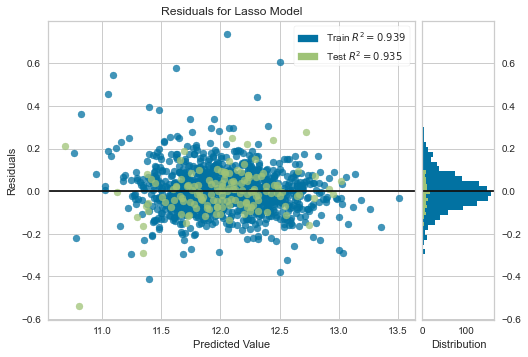

In [120]:
lasso = Lasso(
    alpha = lasso_study.best_params['alpha'],
    warm_start = lasso_study.best_params['warm_start'],
    selection = lasso_study.best_params['selection'],
    random_state=1)
scaler = StandardScaler()
pipe_lasso = make_pipeline(scaler, lasso)

visualizer = ResidualsPlot(pipe_lasso)

visualizer.fit(X_t.values, y_t)  # Fit the training data to the visualizer
visualizer.score(X_val.values, y_val)  # Evaluate the model on the test data
visualizer.show();

The residuals seem to be independent and centered at zero. Cannot really capture a trend in it and the variance is also somewhat uniform across the residuals.

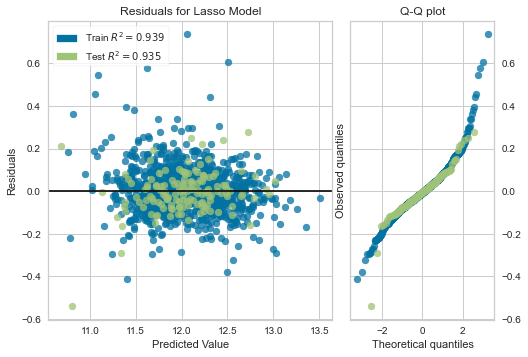

In [122]:
lasso = Lasso(
    alpha = lasso_study.best_params['alpha'],
    warm_start = lasso_study.best_params['warm_start'],
    selection = lasso_study.best_params['selection'],
    random_state=1)
scaler = StandardScaler()
pipe_lasso = make_pipeline(scaler, lasso)

visualizer = ResidualsPlot(pipe_lasso, hist=False, qqplot=True)

visualizer.fit(X_t.values, y_t)  # Fit the training data to the visualizer
visualizer.score(X_val.values, y_val)  # Evaluate the model on the test data
visualizer.show();

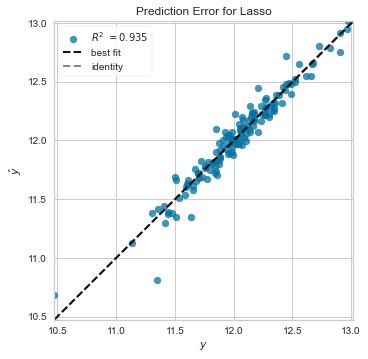

In [123]:
lasso = Lasso(
    alpha = lasso_study.best_params['alpha'],
    warm_start = lasso_study.best_params['warm_start'],
    selection = lasso_study.best_params['selection'],
    random_state=1)
scaler = StandardScaler()
pipe_lasso = make_pipeline(scaler, lasso)

visualizer = PredictionError(pipe_lasso)

visualizer.fit(X_t.values, y_t)  # Fit the training data to the visualizer
visualizer.score(X_val.values, y_val)  # Evaluate the model on the test data
visualizer.show();    

The predictions are a bit biased if the true value of the response variable is lower. Otherwise the assumption of linearity holds.

In [124]:
def calculate_residuals(model, features, label):
    """
    Creates predictions on the features with the model and calculates residuals
    """
    predictions = model.predict(features)
    df_results = pd.DataFrame({'Actual': label, 'Predicted': predictions})
    df_results['Residuals'] = abs(df_results['Actual']) - abs(df_results['Predicted'])
    
    return df_results

In [129]:
def normal_errors_assumption(model, features, label, p_value_thresh=0.05):
    """
    Normality: Assumes that the error terms are normally distributed. If they are not,
    nonlinear transformations of variables may solve this.
               
    This assumption being violated primarily causes issues with the confidence intervals
    """
    from statsmodels.stats.diagnostic import normal_ad
    print('Assumption 2: The error terms are normally distributed', '\n')
    
    # Calculating residuals for the Anderson-Darling test
    df_results = calculate_residuals(model, features, label)
    
    print('Using the Anderson-Darling test for normal distribution')

    # Performing the test on the residuals
    p_value = normal_ad(df_results['Residuals'])[1]
    print('p-value from the test - below 0.05 generally means non-normal:', p_value)
    
    # Reporting the normality of the residuals
    if p_value < p_value_thresh:
        print('Residuals are not normally distributed')
    else:
        print('Residuals are normally distributed')
    
    # Plotting the residuals distribution
    plt.subplots(figsize=(12, 6))
    plt.title('Distribution of Residuals')
    sns.distplot(df_results['Residuals'])
    plt.show()
    
    print()
    if p_value > p_value_thresh:
        print('Assumption satisfied')
    else:
        print('Assumption not satisfied')
        print('Confidence intervals will likely be affected')

Assumption 2: The error terms are normally distributed 

Using the Anderson-Darling test for normal distribution
p-value from the test - below 0.05 generally means non-normal: 0.0
Residuals are not normally distributed


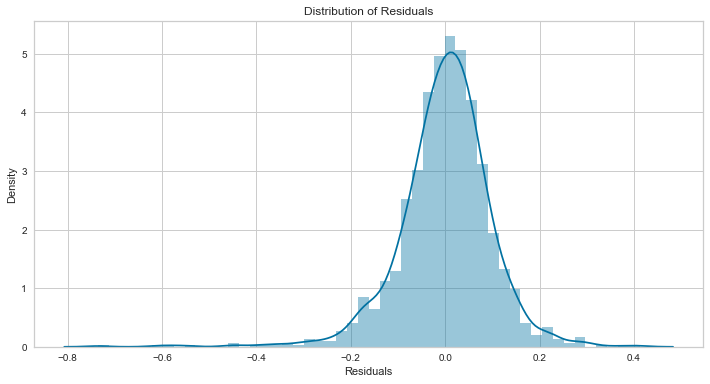


Assumption not satisfied
Confidence intervals will likely be affected


In [130]:
normal_errors_assumption(pipe_lasso, X_t, y_t)

Assumption 2: The error terms are normally distributed 

Using the Anderson-Darling test for normal distribution
p-value from the test - below 0.05 generally means non-normal: 0.0001543370184142727
Residuals are not normally distributed


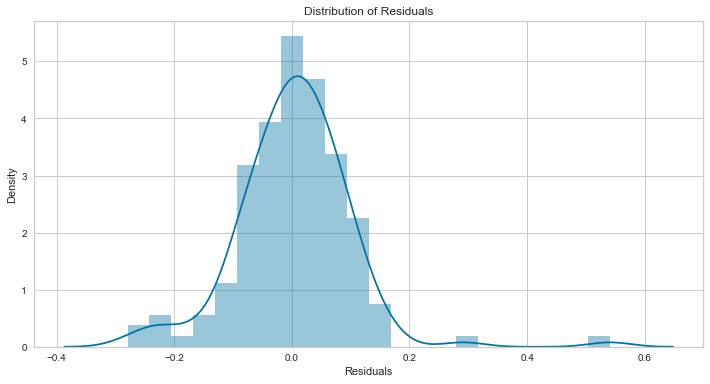


Assumption not satisfied
Confidence intervals will likely be affected


In [131]:
normal_errors_assumption(pipe_lasso, X_val, y_val)

Eventhough they are centered, because of the heavy tails and extremes the assumption of normality does not hold. Nevertheless, the predictions are quite good.<br>
We can also observe that the residuals of the train set have more extremes in the negative values and the distribution of the validation set is more heavy-tailed in the positive values.

## Lasso submission

In [98]:
lasso = Lasso(
    alpha = lasso_study.best_params['alpha'],
    warm_start = lasso_study.best_params['warm_start'],
    selection = lasso_study.best_params['selection'],
    random_state=1)
scaler = StandardScaler()
pipe_lasso = make_pipeline(scaler, lasso)
pipe_lasso.fit(X_t.values, y_t)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('lasso',
                 Lasso(alpha=0.002727, random_state=1, selection='random'))])

In [99]:
X_test = test_df.drop(['SalePrice'], axis=1)
y_test = test_df['SalePrice']
y_test_pred = pipe_lasso.predict(X_test.values)

In [100]:
submission = pd.read_csv('sample_submission.csv')
submission.drop(['SalePrice'], axis=1, inplace=True)
submission['SalePrice'] = y_test_pred
submission.iloc[:,1] = np.expm1(y_test_pred) # transform back
submission.to_csv('submission_lasso.csv', index=False)

Indeed, the Lasso outperformed the random forest approach. Kaggle score: 0.12687